## Временный ряды

### Задача: <u>проанализировать ВВП африканской страны Гана.</u>

### Данные: <u>показатели [ВВП Ганы](https://lms.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip) за 62 года.</u>


### Задания для проекта: 
<a class="anchor" id=0></a>

1. [Чтение и визуализация исходных данных.](#1)
2. [Модель скользящего среднего.](#2)
3. [Подбор параметров модели).](#3)
4. [Построение модели по оптимальным параметрам.](#4)
5. [Визуализация результатов.](#5)
6. [Выводы по полученным результатам.](#6)
7. [Проверка на наличие пропущенных дат.](#7)
8. [Проверка на наличие пропущенных значений.](#8)
9. [Заполнение пропусков](#9)
10. [Перестройка модели](#10)
11. [Разница моделей по критерию Акаике](#11)
12. [Волативность временного ряда.](#12)
13. [GARCH-модель для предсказания волатильности.](#13)
14. [LinearRegression для получения прогноза.](#14)
15. [Визуализация предсказаний.](#15)
16. [Выводы по волативности.](#16)
17. [Итоговый вариант.](#17)



### Критерии оцненивания:

| Задача | Балл |
| - | - |
| Временной ряд проанализирован на наличие тренда и сезонности, проверен на стационарность |1|
Выбор модели обоснован |2|
Выполнена интерполяция | 1|
Произведён расчёт волатильности, применена ARCH/GARCH-модель |2 |
Приведено сравнение результатов с результатами применения линейной регрессии |2|
Результаты корректно валидированы | 2 |

### 0. Импортируем нужные библиотеки

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels.graphics.tsaplots as sgt
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from parametricGarch import Garch
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

### 1. Читаем и визуализируем данные <a class="anchor" id=1></a>


[наверх](#0)

In [44]:
df = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df = df.rename(columns={'GDP (current US$)':'gdp'})
df.tail()

,gdp
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


In [73]:
df.tail()

,gdp
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


adf:  -5.278476343687495
p-value:  6.0666917115542805e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен
Уровень дифференцирования = 3


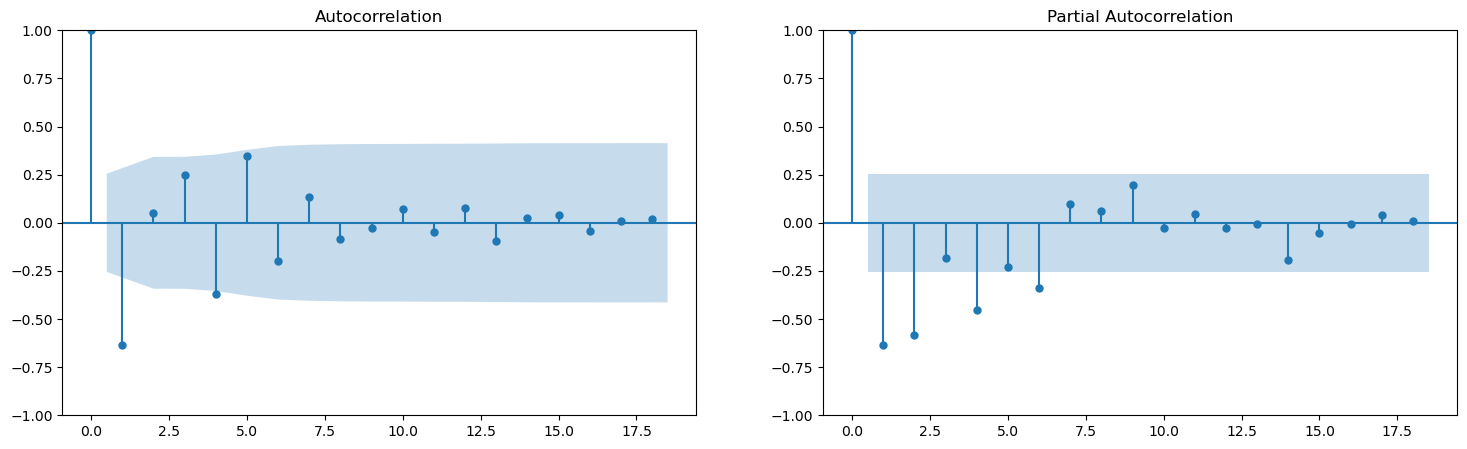

None

In [59]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5
    fig, axes = plt.subplots(1, 2)
    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1])
    plt.show()

# Функция дифференцирования временного радя
def diff_c(df_diff, d):
    df_diff = df_diff.diff().dropna()
    diki_fuler(df_diff, d)
    return df_diff

# Функция проверки на стационарность временного ряда методом Дики-Фуллера
def diki_fuler(df, d):
    test = adfuller(df)
    if test[0]> test[4]['5%']:
        d += 1 
        diff_c(df, d)
    else:
        print ('adf: ', test[0])
        print ('p-value: ', test[1])
        print ('Critical values: ', test[4])
        print ('ряд стационарен')
        print(f'Уровень дифференцирования = {d}')

        # Построение графиков Автокорреляции и Частичной автокорреляции
        fig = plot_acf_pacf(df)
        return df

new_df = diki_fuler(df, d=0)
display(new_df)

In [92]:
def useless_function(df, critical_value='5%'):
    copy_df = df.copy()
    adf = 0
    critical_values = {'1%':0, '5%':0, '10%':0}
    d = 0
    while adf >= critical_values[critical_value]:
        adf = adfuller(copy_df)[0]
        critical_values['1%'] = adfuller(copy_df)[4]['1%']
        critical_values['5%'] = adfuller(copy_df)[4]['5%']
        critical_values['10%'] = adfuller(copy_df)[4]['10%']
        copy_df = copy_df.diff().dropna()
        d += 1
    return (d-1, copy_df)  

d, new_df = useless_function(df)

print(d)
display(new_df)

3


,gdp
year,
1964-01-01,5.079832e+09
1965-01-01,-1.156863e+09
1966-01-01,-4.803922e+08
1967-01-01,1.781786e+08
1968-01-01,9.541958e+08
1969-01-01,-6.757335e+08
1970-01-01,-4.928886e+08
1971-01-01,4.084632e+08
1972-01-01,-4.472563e+08


In [87]:
test = adfuller(df.diff().diff().diff().dropna()) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -5.278476343687495
p-value:  6.0666917115542805e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


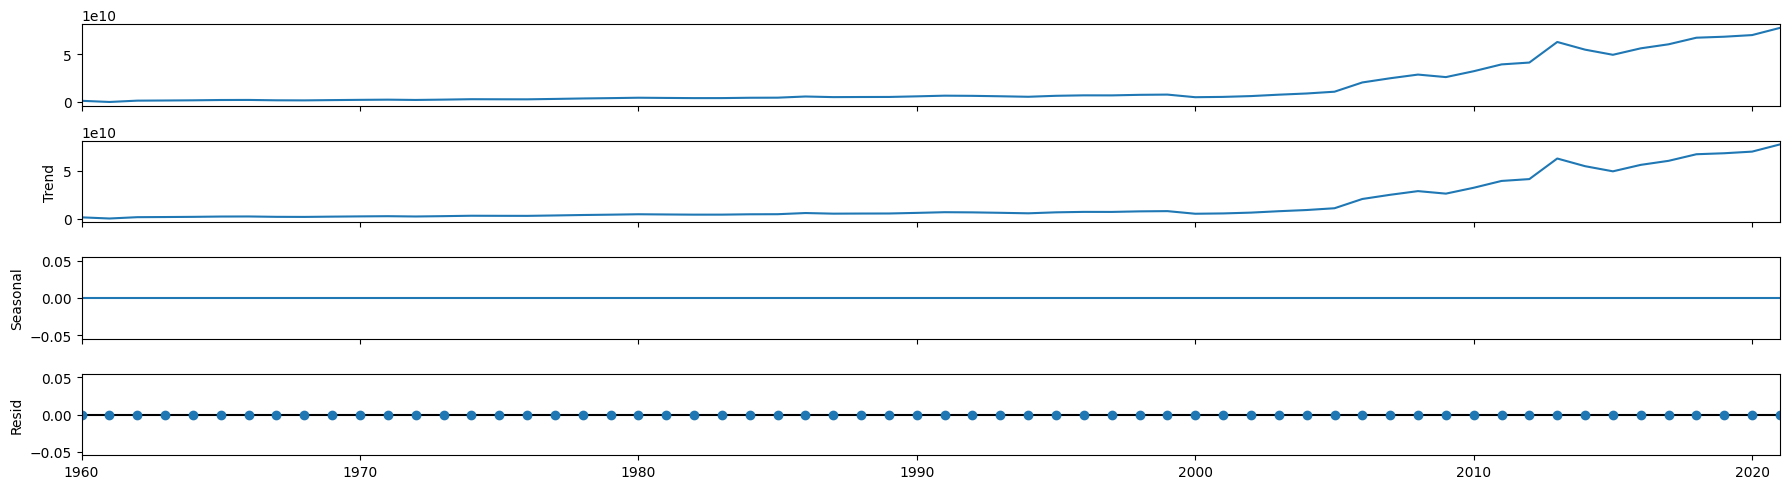

In [13]:
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

### Первичный выводы:

* Присутствует явно выраженный тренд роста

* Сезонность отсутствует

In [3]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
train_df.shape, test_df.shape

((59, 1), (3, 1))

In [4]:
from statsmodels.tsa.api import SimpleExpSmoothing

ses = SimpleExpSmoothing(df)

alpha = 0.7

model = ses.fit(smoothing_level = alpha, optimized = False)

forecast = model.forecast(1)

print(forecast)

2022-01-01    7.507760e+10
Freq: AS-JAN, dtype: float64


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


### 2. Модель скользящего среднего. <a class="anchor" id=2></a>

[наверх](#0)

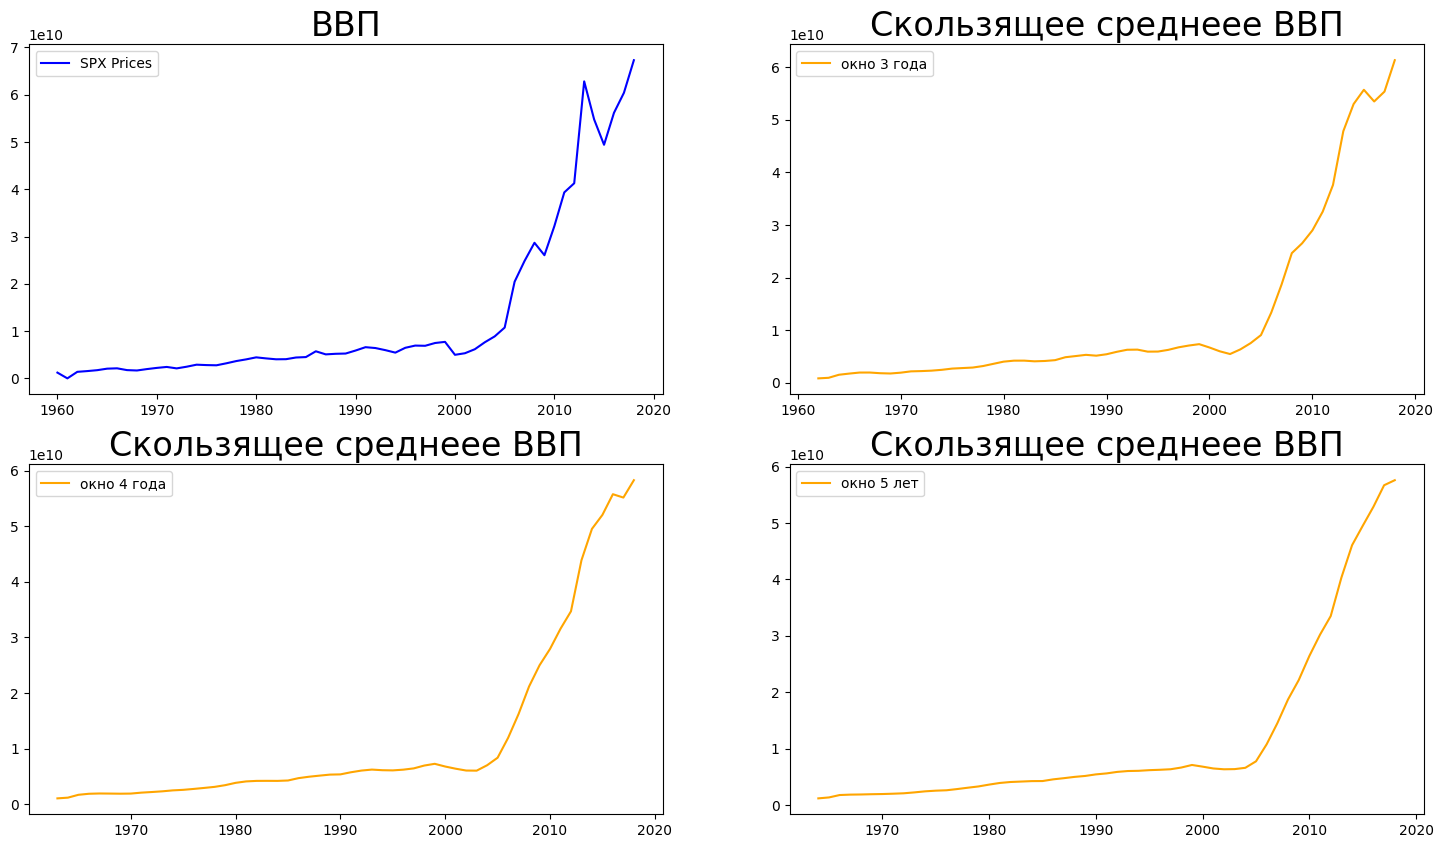

In [16]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в 3 года (Window = 3)
ax[0, 0].plot(train_df.gdp, color="blue", label="SPX Prices")
ax[0, 0].set_title("ВВП", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.gdp.rolling(window=3).mean(),
    color="orange",
    label="окно 3 года")
ax[0, 1].set_title("Скользящее среднеее ВВП", size=24)
ax[0, 1].legend()


# Окно в 5 лет (Window = 5)
ax[1, 0].plot(
    train_df.rolling(window=4).mean(), 
    color="orange", label="окно 4 года")
ax[1, 0].set_title("Скользящее среднеее ВВП", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.gdp.rolling(window=5).mean(),
    color="orange",
    label="окно 5 лет")
ax[1, 1].set_title("Скользящее среднеее ВВП", size=24)
ax[1, 1].legend()

plt.show()

Построим модель `ARMA`

In [5]:
model = SARIMAX(train_df.gdp)
model_fit = model.fit()

pred_df = pd.DataFrame(index=test_df.index)

pred_df["model_preds"] = model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["gdp"] = test_df["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))

old_aic = model_fit.aic

model_fit.summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    gdp   No. Observations:                   59
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1390.766
Date:                Sat, 06 Apr 2024   AIC                           2785.533
Time:                        17:22:08   BIC                           2789.688
Sample:                    01-01-1960   HQIC                          2787.155
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9964      0.006    166.517      0.000       0.985       1.008
sigma2      1.358e+19   1.96e-23   6.93e+41      0.000    1.36e+19    1.36e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               479.75
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             189.08   Skew:                             2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

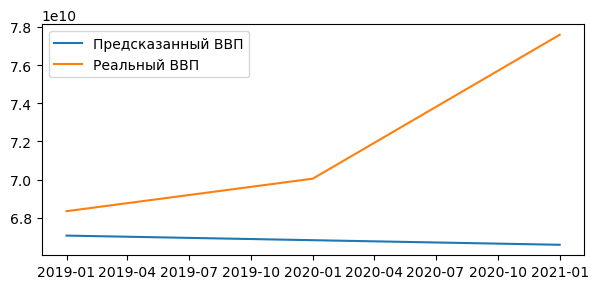

In [6]:
plt.rcParams["figure.figsize"] = 7, 3
plt.plot(
    pred_df.model_preds,
    label="Предсказанный ВВП")
plt.plot(
    pred_df.gdp,
    label="Реальный ВВП")
plt.legend()

### Промежуточные выводы:

* C параметрами по умолчанию предсказания модели оставляют делать лучшего

### 3. Подбор параметров модели. <a class="anchor" id=3></a>

[наверх](#0)

Для определения параметров $p$ и $q$ построим коррелограммs (`ACF, PACF`)

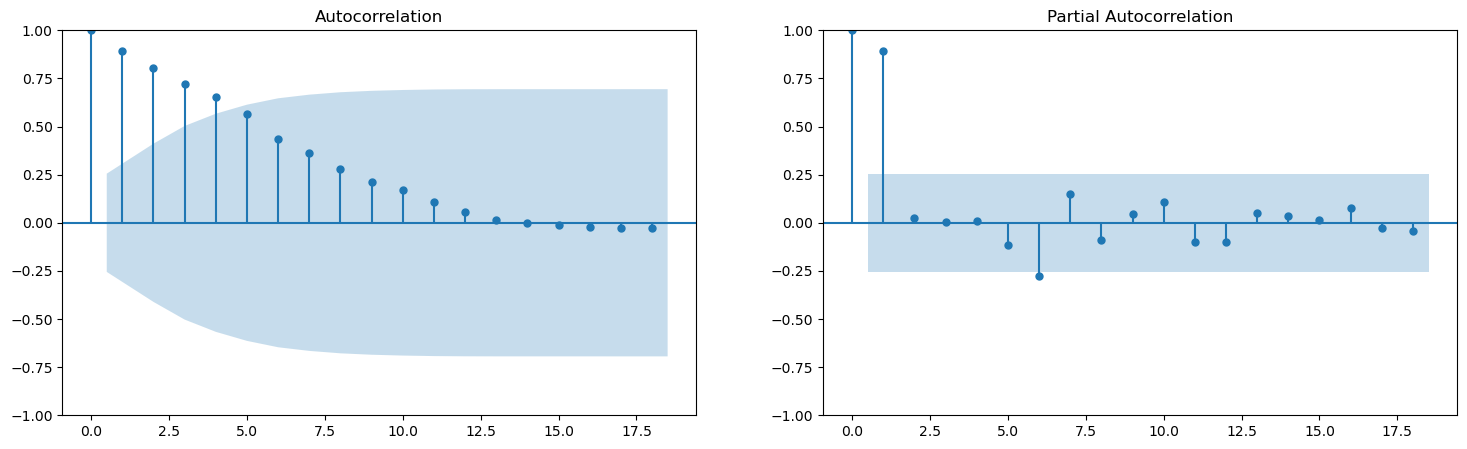

In [7]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0])
    sgt.plot_pacf(series, ax=axes[1])
    plt.show()

plot_acf_pacf(train_df["gdp"].dropna())

Для определения $d$ проведеём тест Дики-Фуллера

In [8]:
test = adfuller(train_df["gdp"]) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885368
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


Исходный ряд нестационарен. Будем дифференцировать ряд, пока не добьёмся стационарности. 

In [9]:
test_1 = adfuller(train_df["gdp"].diff().dropna()) # Первое дифференцирование
print("adf: ", test_1[0])
print("p-value: ", test_1[1])
print("Critical values: ", test_1[4])
if test_1[0] > test_1[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -1.6702483038320775
p-value:  0.4465029329713892
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [10]:
test_2 = adfuller(train_df["gdp"].diff().diff().dropna()) # Второе дифференцирование
print("adf: ", test_2[0])
print("p-value: ", test_2[1])
print("Critical values: ", test_2[4])
if test_2[0] > test_2[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -2.6408690561284796
p-value:  0.0848411691783787
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


Порядок дифференциирования, при котором ряд стационарен $d=2$

Проверим разные значения $p$ и $q$

In [11]:
model_1 = SARIMAX(
    train_df["gdp"].dropna(), order=(1, 1, 3))
model_fit_1 = model_1.fit()

model_2 = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3))
model_fit_2 = model_2.fit()

model_3 = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 2, 3))
model_fit_3 = model_3.fit()

model_4 = SARIMAX(
    train_df["gdp"].dropna(), order=(1, 2, 3))
model_fit_4 = model_4.fit()


pred_df = pd.DataFrame(index=test_df.index)
pred_df["model_1"] = model_fit_1.predict(
    start=test_df.index[0], end=test_df.index[-1])
pred_df["model_2"] = model_fit_2.predict(
    start=test_df.index[0], end=test_df.index[-1])
pred_df["model_3"] = model_fit_3.predict(
    start=test_df.index[0], end=test_df.index[-1])
pred_df["model_4"] = model_fit_4.predict(
    start=test_df.index[0], end=test_df.index[-1])

pred_df["gdp"] = test_df["gdp"]

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-

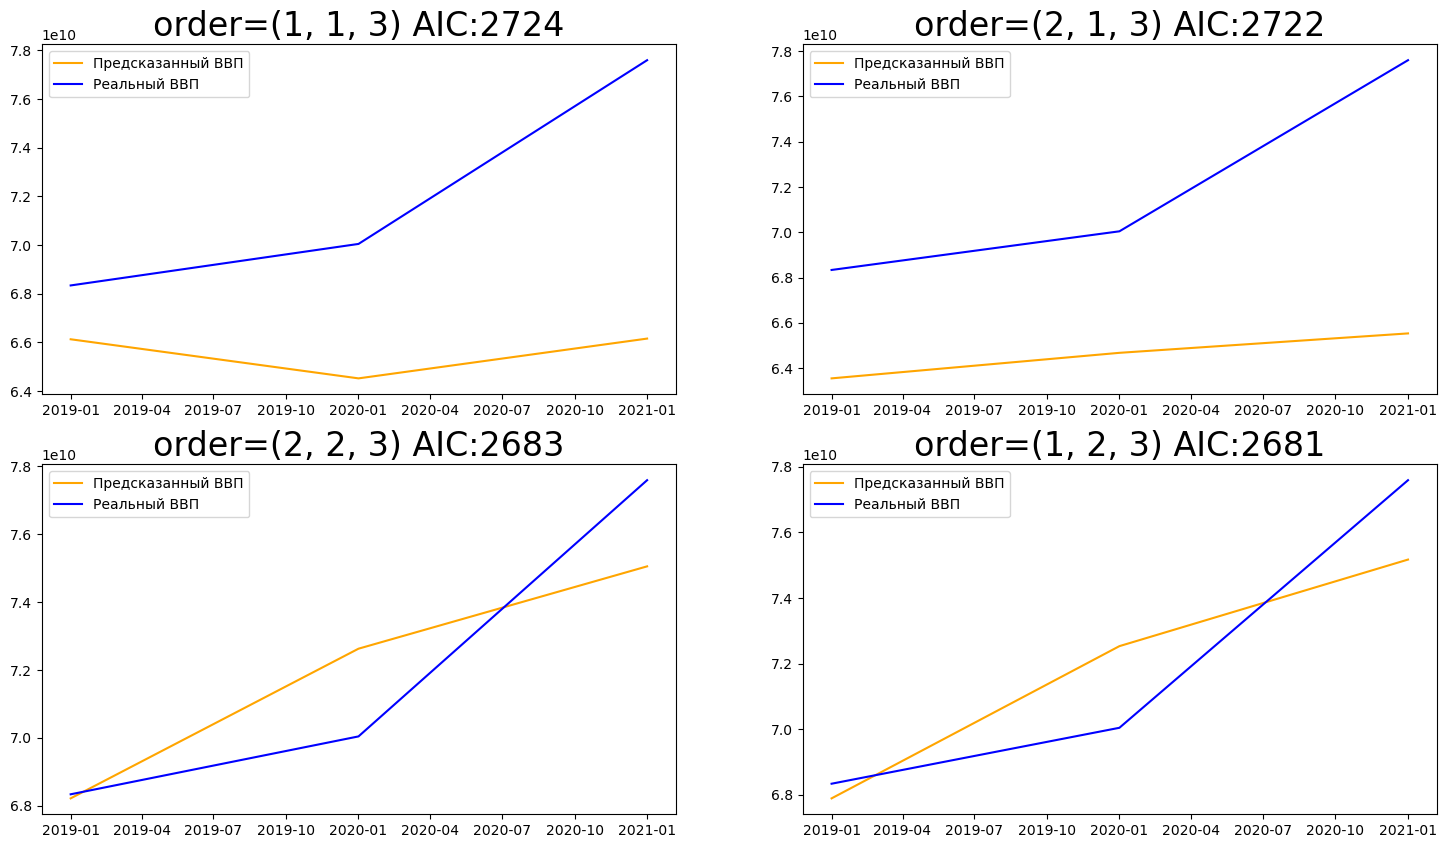

In [12]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(pred_df.model_1, color="orange", label="Предсказанный ВВП")
ax[0, 0].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[0, 0].set_title(f"order=(1, 1, 3) AIC:{round(model_fit_1.aic)}", size=24)
ax[0, 0].legend()

ax[0, 1].plot(pred_df.model_2, color="orange", label="Предсказанный ВВП",)
ax[0, 1].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[0, 1].set_title(f"order=(2, 1, 3) AIC:{round(model_fit_2.aic)}", size=24)
ax[0, 1].legend()

ax[1, 0].plot(pred_df.model_3, color="orange", label="Предсказанный ВВП")
ax[1, 0].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[1, 0].set_title(f"order=(2, 2, 3) AIC:{round(model_fit_3.aic)}", size=24)
ax[1, 0].legend()

ax[1, 1].plot(pred_df.model_4, color="orange", label="Предсказанный ВВП",)
ax[1, 1].plot(pred_df.gdp, color='blue', label="Реальный ВВП")
ax[1, 1].set_title(f"order=(1, 2, 3) AIC:{round(model_fit_4.aic)}", size=24)
ax[1, 1].legend()

plt.show()

Воспользуемся `pmdarima`

In [13]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=5,
    max_q=5,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.818, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.375, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.844, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.273, Time=0.04 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2493.722, Time=0.15 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=2493.670, Time=0.19 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=inf, Time=0.05 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.817, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.547, Time=0.02 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2490.649, Time=0.09 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2497.730, Time=0.09 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2492.646, Time=0.14 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2492.644, Time=0.16 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   59
Model:             SARIMAX(4, 1, 2)x(0, 1, 2, 5)   Log Likelihood               -1235.132
Date:                           Sat, 06 Apr 2024   AIC                           2488.264
Time:                                   17:23:29   BIC                           2505.997
Sample:                               01-01-1960   HQIC                          2495.083
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0811      0.231      0.351      0.725      -0.371       0.534
ar.L2         -1.0582      0.253     -4.185      0.000      -1.554      -0.563
ar.L3          0.4043      0.354      1.143      0.253      -0.289       1.097
ar.L4         -0.3468      0.366     -0.948      0.343      -1.063       0.370
ma.L1         -0.1224      0.179     -0.685      0.493      -0.472       0.228
ma.L2          0.9391      0.255      3.677      0.000       0.439       1.440
ma.S.L5        0.0691      0.425      0.162      0.871      -0.765       0.903
ma.S.L10      -0.4331      0.329     -1.316      0.188      -1.078       0.212
sigma2      1.444e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                55.73
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):              59.74   Skew:                             1.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.87e+55. Standard errors may be unstable.
"""

`pmdarima` советует применить следующие параметры 
```python 
order=(2, 1, 3), 
seasonal_order=(0, 1, 2, 5)
```
Данные параметры соответствуют полученным нами параметрам, на них и остановимся.

### 4. Построим модель с наилучшими параметрами. <a class="anchor" id=4></a>

[наверх](#0)

In [14]:
model = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_fit = model.fit()

pred_df = pd.DataFrame(index=df.index)
pred_df["model_preds"] = model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1])


pred_df["gdp"] = df["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5. Визуализируем промежуточные результаты. <a class="anchor" id=5></a>

[наверх](#0)

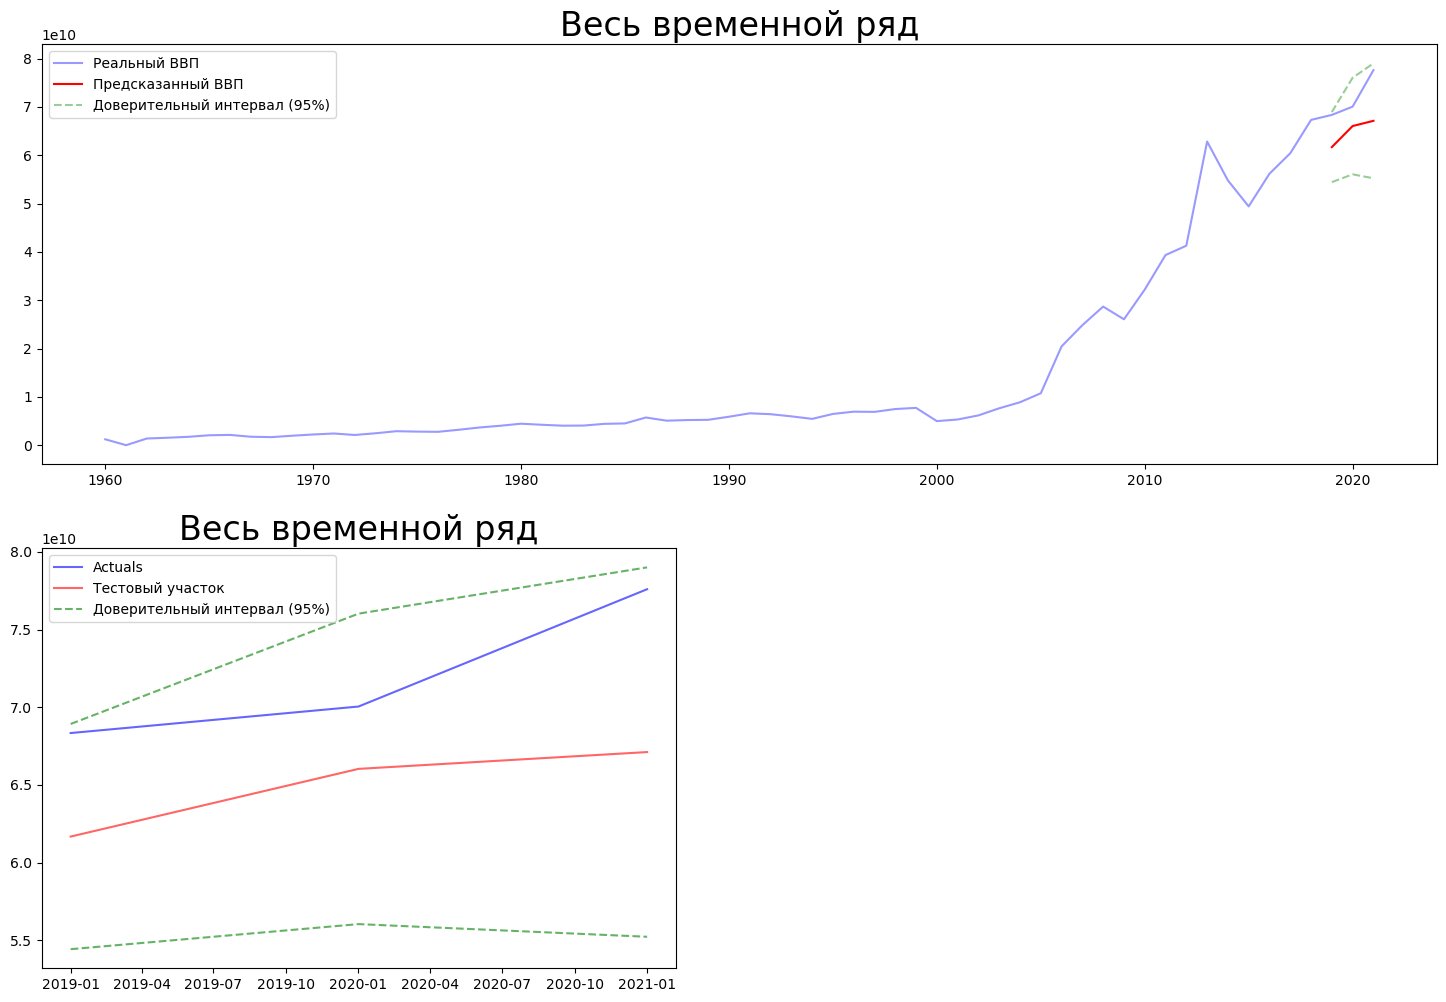

In [15]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Реальный ВВП", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Предсказанный ВВП",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Тестовый участок",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.show()

### 6. Промежеточные разельтаты <a class="anchor" id=6></a>

* С подобранными параметрами модель делает более правдоподобные предсказания


[наверх](#0)

### 7. Проверим пропущенные даты. <a class="anchor" id=7></a>

[наверх](#0)

In [16]:
print(df.asfreq(freq='AS'))
print()
print(f'Пропущенные даты: {(np.arange(1960, 2022) - df.index.year).any() != 0}')

                     gdp
year                    
1960-01-01  1.217087e+09
1961-01-01  0.000000e+00
1962-01-01  1.382353e+09
1963-01-01  1.540616e+09
1964-01-01  1.731092e+09
...                  ...
2017-01-01  6.040638e+10
2018-01-01  6.729928e+10
2019-01-01  6.833754e+10
2020-01-01  7.004320e+10
2021-01-01  7.759428e+10

[62 rows x 1 columns]

Пропущенные даты: False


### 8. Проверим пропущенные значения. <a class="anchor" id=8></a>

[наверх](#0)

In [17]:
df = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df = df.rename(columns={'GDP (current US$)':'gdp'})
df['gdp'] = df['gdp'].apply(lambda x: np.nan if x==0 else x)
df = df.interpolate(method='linear')
print(f'Пропуски в значениях: {df.gdp.isna().any()}')

Пропуски в значениях: False


### 9. Заменим пропуски интерполяцией. <a class="anchor" id=9></a>

[наверх](#0)

In [18]:
df = df.interpolate(method='linear')
print(f'Пропуски в значениях: {df.gdp.isna().any()}')

Пропуски в значениях: False


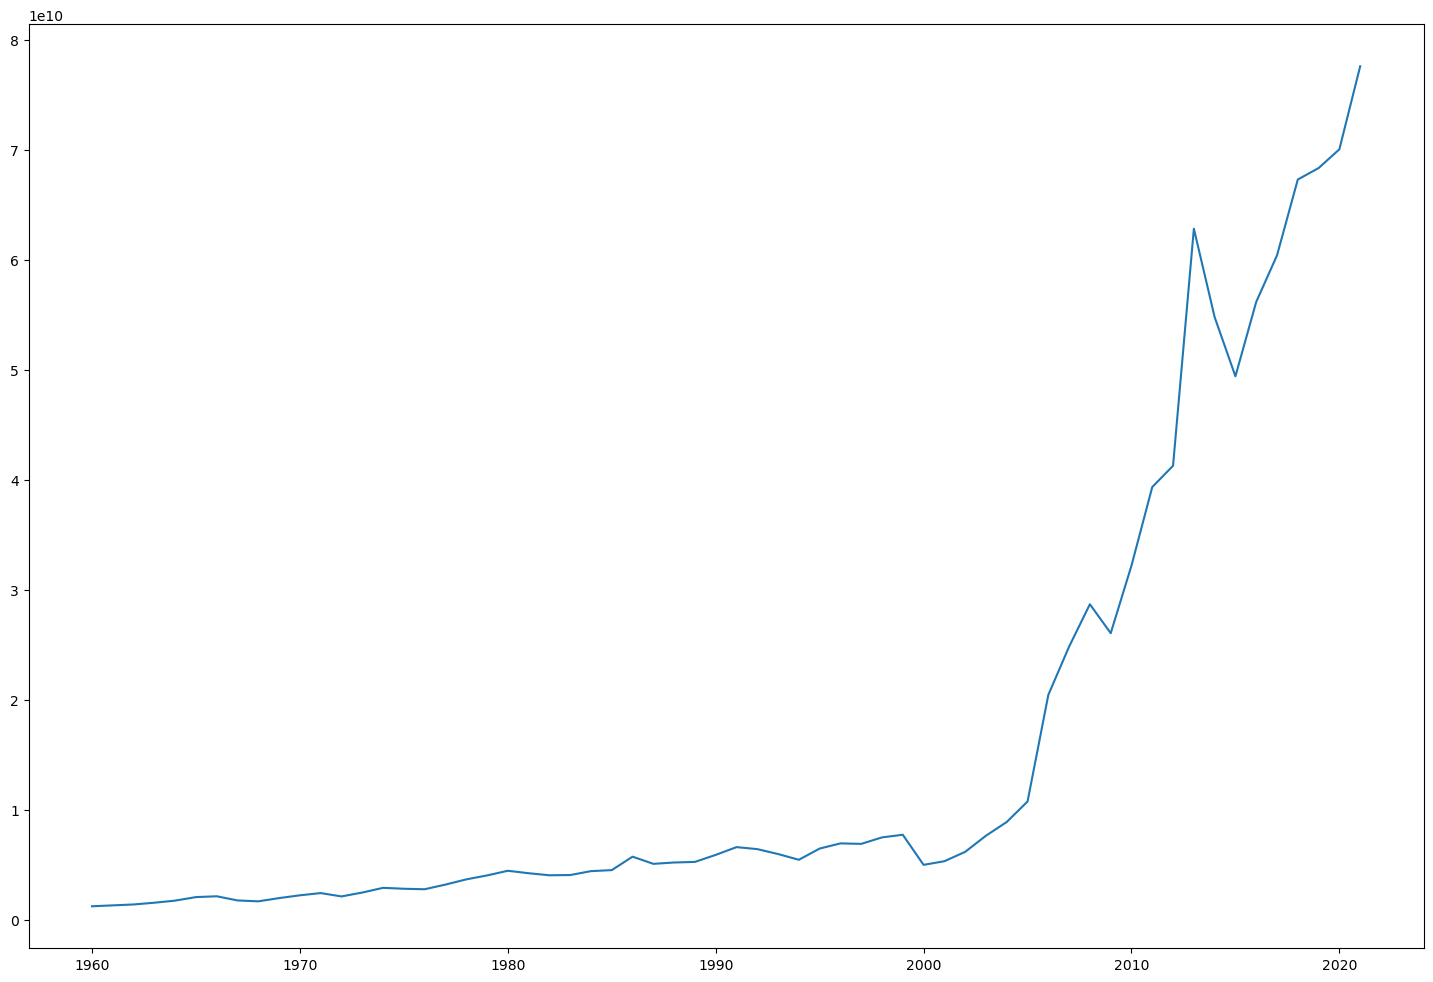

In [19]:
plt.plot(df)

### 10. Построим модель на откорректированных данных. <a class="anchor" id=10></a>

[наверх](#0)

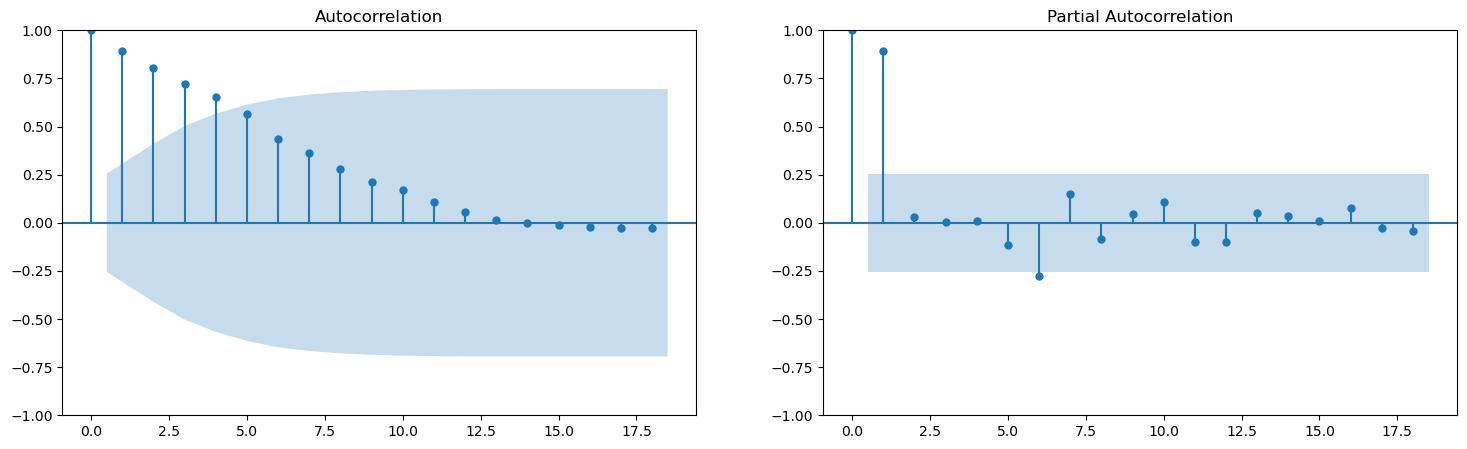

adf:  0.8030073326980144
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [20]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

plot_acf_pacf(train_df["gdp"].dropna())

test = adfuller(train_df["gdp"]) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

In [21]:
test_1 = adfuller(train_df["gdp"].diff().dropna()) # Первое дифференцирование
print("adf: ", test_1[0])
print("p-value: ", test_1[1])
print("Critical values: ", test_1[4])
if test_1[0] > test_1[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -1.8255652246436078
p-value:  0.3678451527656304
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [22]:
test_2 = adfuller(train_df["gdp"].diff().diff().dropna()) # Первое дифференцирование
print("adf: ", test_2[0])
print("p-value: ", test_2[1])
print("Critical values: ", test_2[4])
if test_2[0] > test_2[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  -2.634634746007842
p-value:  0.0860481372219768
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


In [23]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.412, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.105, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.664, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.160, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.03 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=2492.573, Time=0.06 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.412, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.391, Time=0.02 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2489.992, Time=0.08 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=inf, Time=0.06 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2491.982, Time=0.17 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2491.973, Time=0.16 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=inf, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.054
Date:                                Sat, 06 Apr 2024   AIC                           2486.108
Time:                                        17:24:22   BIC                           2501.870
Sample:                                    01-01-1960   HQIC                          2492.169
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4167      0.141     -2.965      0.003      -0.692      -0.141
ar.L2         -0.9824      0.190     -5.179      0.000      -1.354      -0.611
ma.L1          0.3816      0.242      1.580      0.114      -0.092       0.855
ma.L2          0.9249      0.200      4.618      0.000       0.532       1.317
ma.L3          0.4395      0.187      2.348      0.019       0.073       0.806
ma.S.L5        0.0412      0.265      0.156      0.876      -0.478       0.560
ma.S.L10      -0.4437      0.321     -1.382      0.167      -1.073       0.186
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                70.65
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             181.18   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+54. Standard errors may be unstable.
"""

```python 
order=(2, 1, 3), 
seasonal_order=(0, 1, 2, 5)
```

In [24]:
model_inter = SARIMAX(
    train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_fit_inter = model_inter.fit()

model_fit_inter.summary()

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.054
Date:                                Sat, 06 Apr 2024   AIC                           2486.108
Time:                                        17:24:29   BIC                           2501.870
Sample:                                    01-01-1960   HQIC                          2492.169
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4167      0.141     -2.965      0.003      -0.692      -0.141
ar.L2         -0.9824      0.190     -5.179      0.000      -1.354      -0.611
ma.L1          0.3816      0.242      1.580      0.114      -0.092       0.855
ma.L2          0.9249      0.200      4.618      0.000       0.532       1.317
ma.L3          0.4395      0.187      2.348      0.019       0.073       0.806
ma.S.L5        0.0412      0.265      0.156      0.876      -0.478       0.560
ma.S.L10      -0.4437      0.321     -1.382      0.167      -1.073       0.186
sigma2      1.361e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                70.65
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             181.18   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+54. Standard errors may be unstable.
"""

### 11. Проверим улучшилась ли ключевая метрика модели. <a class="anchor" id=11></a>

[наверх](#0)

In [25]:
print(f'По критерию Акаике новая модель лучше старой на: {round(old_aic - model_fit_inter.aic)}')

По критерию Акаике новая модель лучше старой на: 299


### 12. Определим волативность ряда. <a class="anchor" id=12></a>

[наверх](#0)

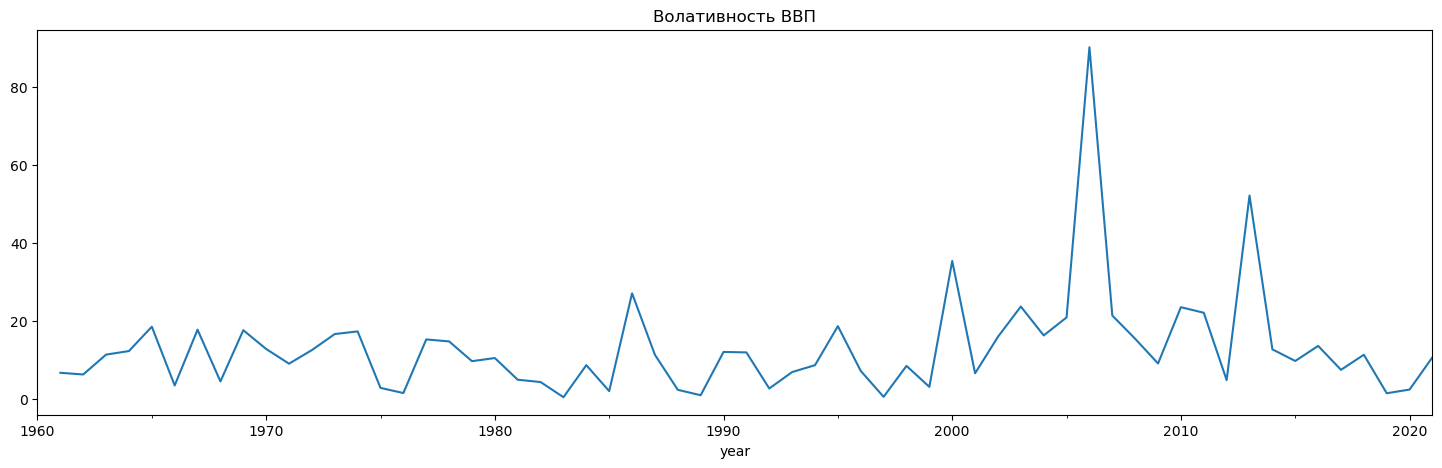

In [26]:
df['gdp_vol'] = (df.gdp - df.gdp.shift(1))/df.gdp.shift(1)
df['gdp_vol'] = df.gdp.pct_change(1).mul(100).abs()

df['gdp_vol'].plot()
plt.title('Волативность ВВП')
plt.show()

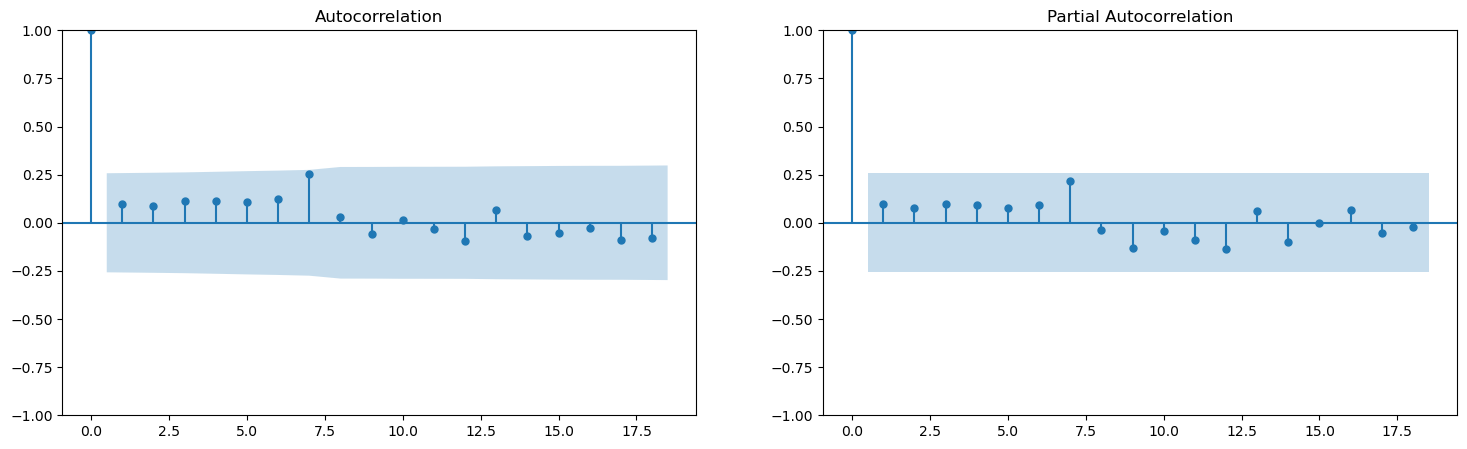

adf:  -6.725311059553778
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


In [27]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

plot_acf_pacf(train_df["gdp_vol"].dropna())

test = adfuller(train_df["gdp_vol"].dropna()) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

Iteration:      3,   Func. Count:     23,   Neg. LLF: 240.39116873348152
Iteration:      6,   Func. Count:     43,   Neg. LLF: 226.3704962577482
Iteration:      9,   Func. Count:     62,   Neg. LLF: 225.85405134314607
Iteration:     12,   Func. Count:     81,   Neg. LLF: 225.8468634908159
Iteration:     15,   Func. Count:    100,   Neg. LLF: 225.84671287075653
Iteration:     18,   Func. Count:    120,   Neg. LLF: 225.84668017367085
Optimization terminated successfully    (Exit mode 0)
            Current function value: 225.846679466596
            Iterations: 18
            Function evaluations: 121
            Gradient evaluations: 18


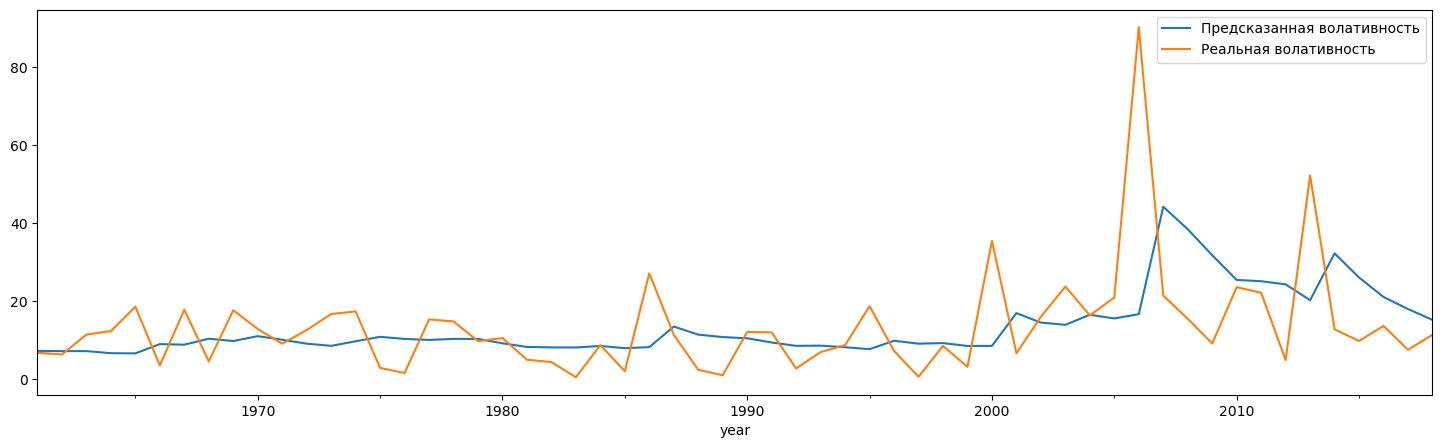

In [28]:
from arch import arch_model
am = arch_model(train_df.gdp_vol.dropna(), p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=3)
plot_df = pd.concat([res.conditional_volatility, train_df.gdp_vol.dropna()], axis=1)
plot_df.columns = ["Предсказанная волативность", "Реальная волативность"]
subplot = plot_df.plot()

Iteration:      3,   Func. Count:     20,   Neg. LLF: 8.468630830091106
Iteration:      6,   Func. Count:     38,   Neg. LLF: 8.459727908264592
Iteration:      9,   Func. Count:     56,   Neg. LLF: 8.459533545656027
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.459533545656027
            Iterations: 10
            Function evaluations: 61
            Gradient evaluations: 10


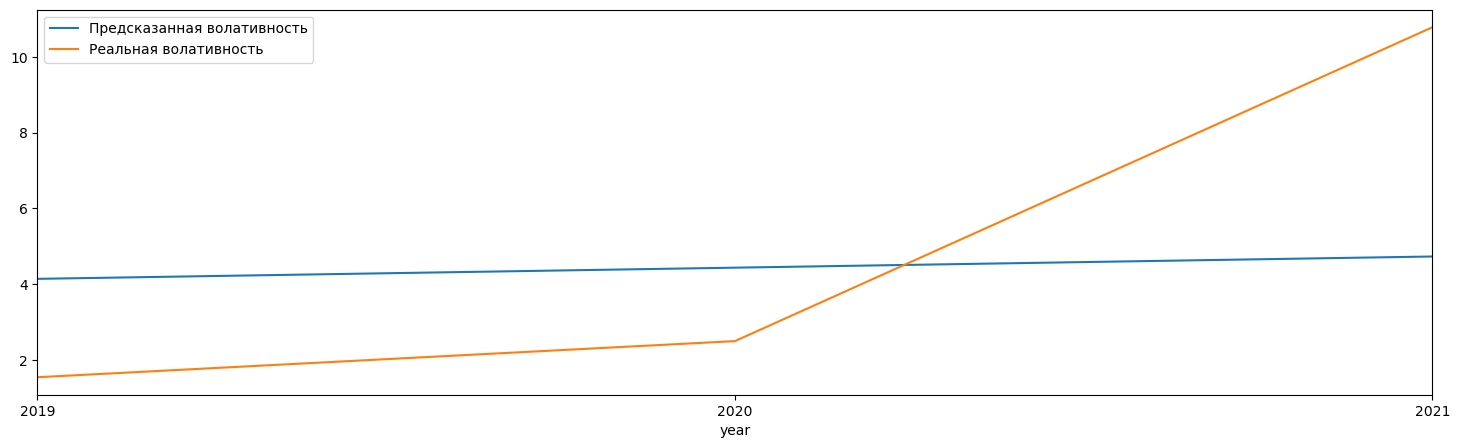

In [29]:
from arch import arch_model
am = arch_model(test_df.gdp_vol.dropna(), p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=3)
plot_df = pd.concat([res.conditional_volatility, test_df.gdp_vol.dropna()], axis=1)
plot_df.columns = ["Предсказанная волативность", "Реальная волативность"]
subplot = plot_df.plot()

Модель предсказывает лютую волативность, я не согласен с моделью. Может бы я разберусь,что я делаю не так, а может быть нет.

### 14 - 15. Линейная регрессия и визуализация <a class="anchor" id=14></a> <a class="anchor" id=15></a>

[наверх](#0)

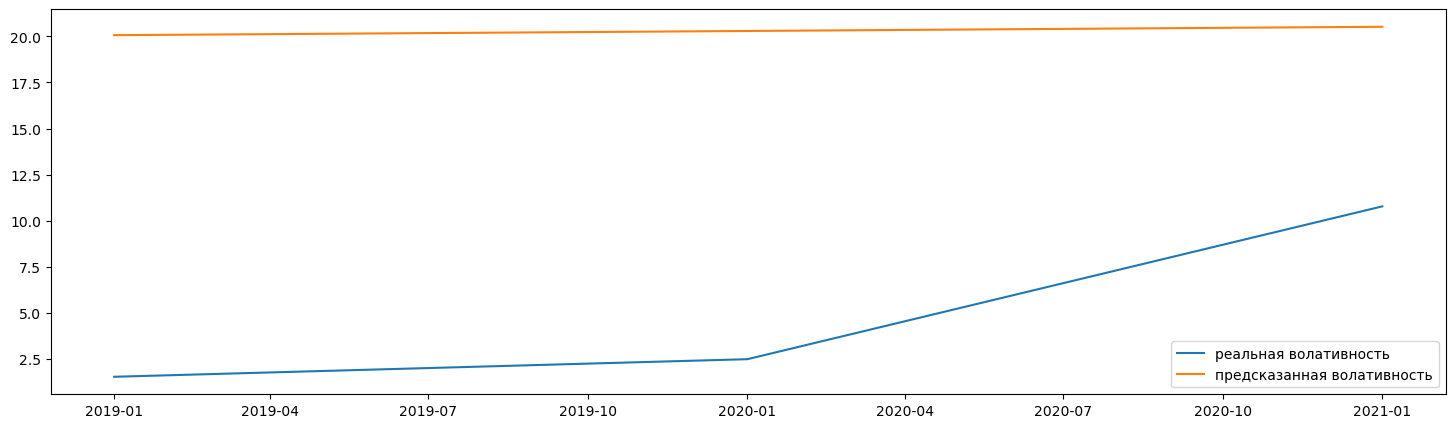

In [30]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(df["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test, label='реальная волативность')
plt.plot(pd.Series(lr_predict, index=y_test.index), label='предсказанная волативность')
plt.legend()
plt.show()

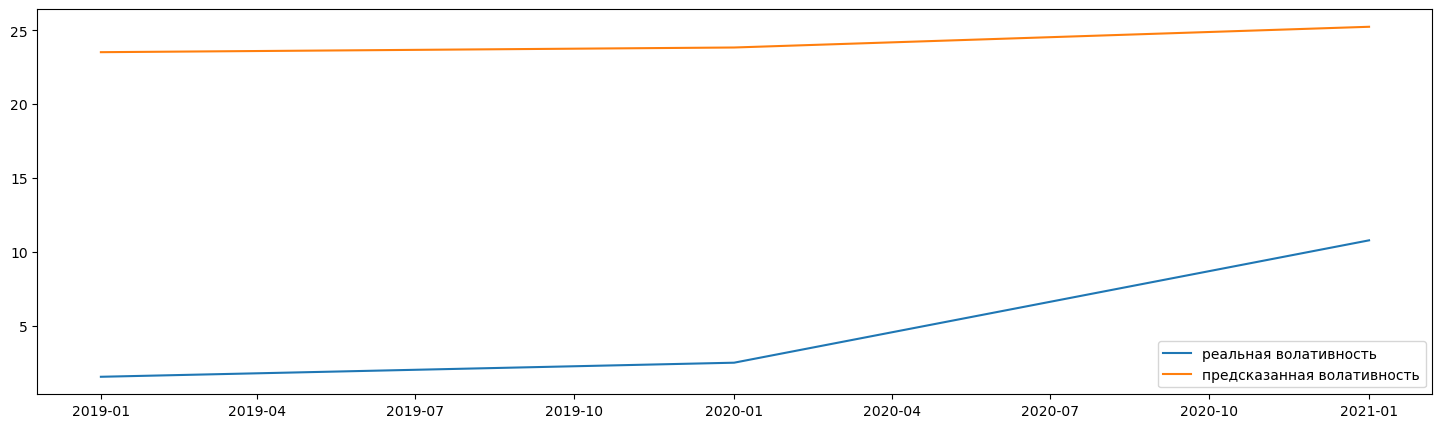

In [31]:
X_train = train_df.drop('gdp_vol', axis=1)
y_train = train_df.drop('gdp', axis=1)

X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

X_test = test_df.drop('gdp_vol', axis=1)
y_test = test_df.drop('gdp', axis=1)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
y_test['pred_vol'] = lr_predict

plt.plot(y_test.gdp_vol, label='реальная волативность')
plt.plot(y_test.pred_vol, label='предсказанная волативность')
plt.legend()
plt.show()

### Выводы по волативности:

* Данные показывают слабую волативность (логично, данных мало, и они не предполагают сильного разброса величин)

* Предсказания `GARCH` выглядят поадекватнее `LinearRegression`.

### 16. Валидация временного ряда <a class="anchor" id=16>

[наверх](#0)

In [32]:
tscv = TimeSeriesSplit(n_splits=5, test_size=7)

train_test_groups = tscv.split(df.gdp)
train_test_groups


train = []
test = []
i = 0
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index), "Split: ", i)
    train.append(train_index)
    test.append(test_index)
    i += 1

TRAIN size: 27 TEST size: 7 Split:  0
TRAIN size: 34 TEST size: 7 Split:  1
TRAIN size: 41 TEST size: 7 Split:  2
TRAIN size: 48 TEST size: 7 Split:  3
TRAIN size: 55 TEST size: 7 Split:  4


In [33]:
model_0 = SARIMAX(
    df.gdp.iloc[train[0]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_0 = model_0.fit()
cv_aic_0 = model_0.aic

model_1 = SARIMAX(
    df.gdp.iloc[train[1]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_1 = model_1.fit()
cv_aic_1 = model_1.aic

model_2 = SARIMAX(
    df.gdp.iloc[train[2]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_2 = model_2.fit()
cv_aic_2 = model_2.aic

model_3 = SARIMAX(
    df.gdp.iloc[train[3]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_3 = model_3.fit()
cv_aic_3 = model_3.aic

model_4 = SARIMAX(
    df.gdp.iloc[train[4]], order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_4 = model_4.fit()
cv_aic_4 = model_4.aic

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-

In [34]:
pred_df = pd.DataFrame(index = df.index)

pred_df["model_0_preds"] = model_0.predict(start=df.gdp.iloc[test[0]].index[0] , end=df.gdp.iloc[test[0]].index[-1])
pred_df["model_1_preds"] = model_1.predict(start=df.gdp.iloc[test[1]].index[0] , end=df.gdp.iloc[test[1]].index[-1])
pred_df["model_2_preds"] = model_2.predict(start=df.gdp.iloc[test[2]].index[0] , end=df.gdp.iloc[test[2]].index[-1])
pred_df["model_3_preds"] = model_3.predict(start=df.gdp.iloc[test[3]].index[0] , end=df.gdp.iloc[test[3]].index[-1])
pred_df["model_4_preds"] = model_4.predict(start=df.gdp.iloc[test[4]].index[0] , end=df.gdp.iloc[test[4]].index[-1])
pred_df["gdp"] = df["gdp"]

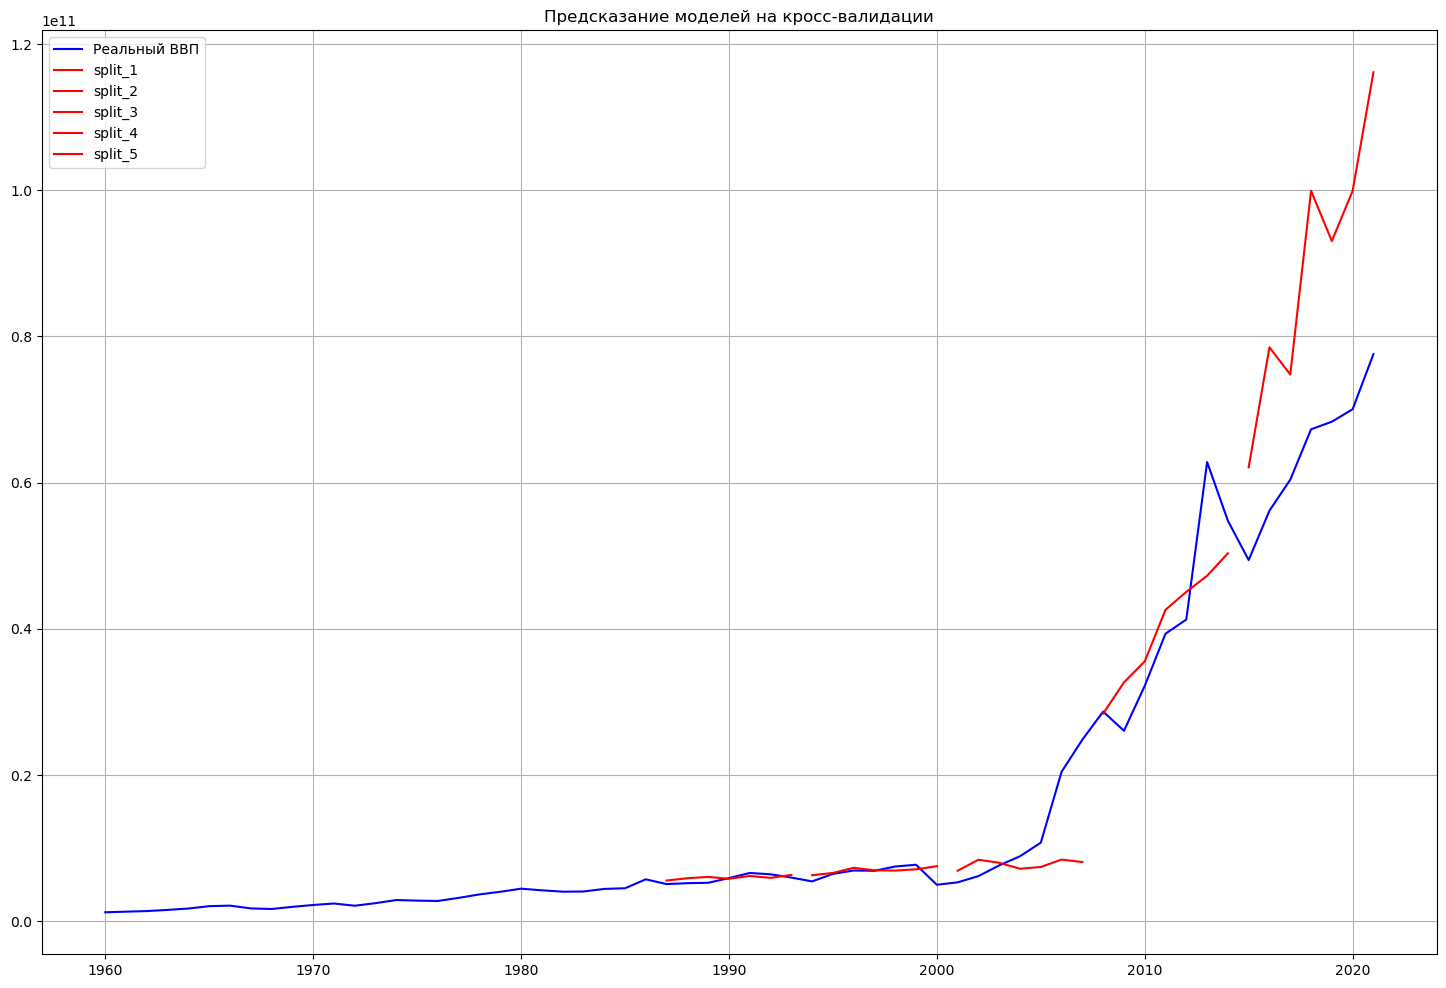

In [35]:
plt.rcParams["figure.figsize"] = 18, 12
plt.grid()

plt.plot(
    pred_df['gdp'],
    color="blue", 
    label="Реальный ВВП"
)
plt.plot(
    pred_df['model_0_preds'],
    color="red", 
    label="split_1"
)
plt.plot(
    pred_df['model_1_preds'],
    color="red", 
    label="split_2"
)
plt.plot(
    pred_df['model_2_preds'],
    color="red", 
    label="split_3"
)
plt.plot(
    pred_df['model_3_preds'],
    color="red", 
    label="split_4"
)
plt.plot(
    pred_df['model_4_preds'],
    color="red", 
    label="split_5"
)
plt.title("Предсказание моделей на кросс-валидации")
plt.legend()

In [36]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

print(f"split_1 R2-score: {round(r2_score(pred_df.loc[pred_df['model_0_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_0_preds'].dropna().index]['model_0_preds']),2)}")
print(f"split_2 R2-score: {round(r2_score(pred_df.loc[pred_df['model_1_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_1_preds'].dropna().index]['model_1_preds']),2)}")
print(f"split_3 R2-score: {round(r2_score(pred_df.loc[pred_df['model_2_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_2_preds'].dropna().index]['model_2_preds']),2)}")
print(f"split_4 R2-score: {round(r2_score(pred_df.loc[pred_df['model_3_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_3_preds'].dropna().index]['model_3_preds']),2)}")
print(f"split_5 R2-score: {round(r2_score(pred_df.loc[pred_df['model_4_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_4_preds'].dropna().index]['model_4_preds']),2)}")
print()
print(f"split_1 MAPE: {round(mape(pred_df.loc[pred_df['model_0_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_0_preds'].dropna().index]['model_0_preds']),2)}")
print(f"split_2 MAPE: {round(mape(pred_df.loc[pred_df['model_1_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_1_preds'].dropna().index]['model_1_preds']),2)}")
print(f"split_3 MAPE: {round(mape(pred_df.loc[pred_df['model_2_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_2_preds'].dropna().index]['model_2_preds']),2)}")
print(f"split_4 MAPE: {round(mape(pred_df.loc[pred_df['model_3_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_3_preds'].dropna().index]['model_3_preds']),2)}")
print(f"split_5 MAPE: {round(mape(pred_df.loc[pred_df['model_4_preds'].dropna().index]['gdp'], pred_df.loc[pred_df['model_4_preds'].dropna().index]['model_4_preds']),2)}")
print()
print(f"split_1 AIC: {round(cv_aic_0,2)}")
print(f"split_2 AIC: {round(cv_aic_1,2)}")
print(f"split_3 AIC: {round(cv_aic_2,2)}")
print(f"split_4 AIC: {round(cv_aic_3,2)}")
print(f"split_5 AIC: {round(cv_aic_4,2)}")


split_1 R2-score: 0.16
split_2 R2-score: -0.3
split_3 R2-score: -0.29
split_4 R2-score: 0.7
split_5 R2-score: -8.15

split_1 MAPE: 0.08
split_2 MAPE: 0.13
split_3 MAPE: 0.35
split_4 MAPE: 0.12
split_5 MAPE: 0.38

split_1 AIC: 910.7
split_2 AIC: 1199.17
split_3 AIC: 1531.44
split_4 AIC: 1906.36
split_5 AIC: 2286.54


Метрики на кросс-валидации любо-дорого смотреть:

* 1ый и 2ой сплиты показываю плюс-минус адекватные результаты

* на 3ем сплите ВВП Ганны резко **полетел вверх** (интересно связано ли это как - то с падение режима Джерри Роулинга и последующей демократизацией Ганны?)

* на 4ом сплите моделька подстроилась под **уверенный рост** ВВП (нет ну серьёзно, как так получается? Сильный, умный, всеми любимый ворждь уходит и жить всем резко становиться богаче и лучше, чудеса...)

* на 5ом сплите модель сильно обгоняет реальный рост ВВП (необходимо учитывать эффект низкой базы)

***
## 17. Итоговый вариант <a class="anchor" id=17>

[наверх](#0)

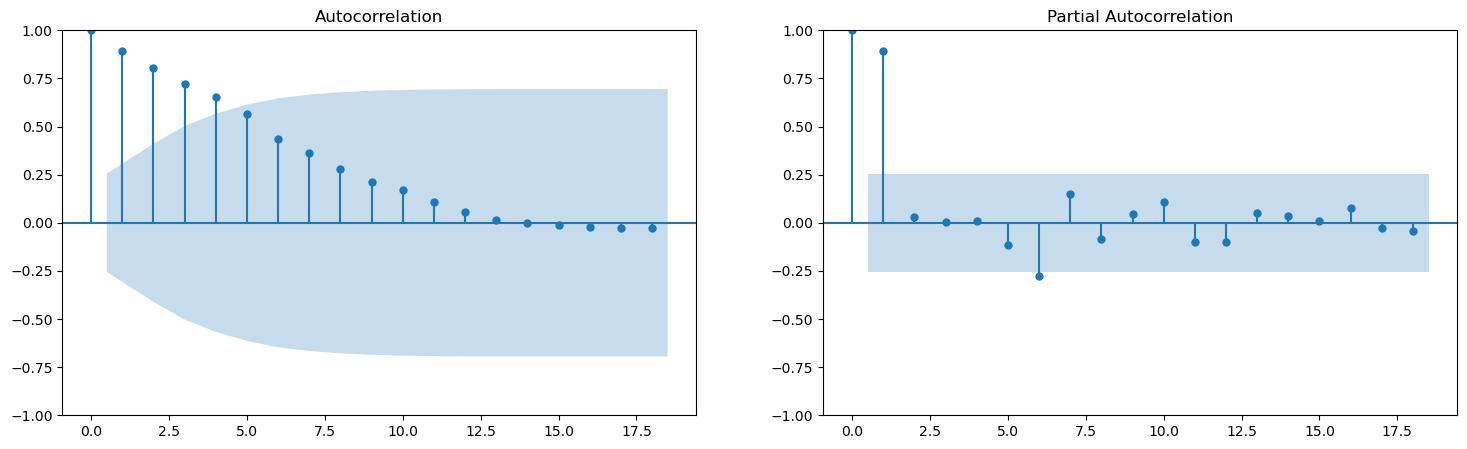

adf:  -2.634634746007842
p-value:  0.0860481372219768
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.054
Date:                                Sat, 06 Apr 2024   AIC                           2486.108
Time:                                        17:25:12   BIC                           2501.870
Sample:                                    01-01-1960   HQIC                          2492.169
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4167      0.141     -2.965      0.003      -0.692      -0.141
ar.

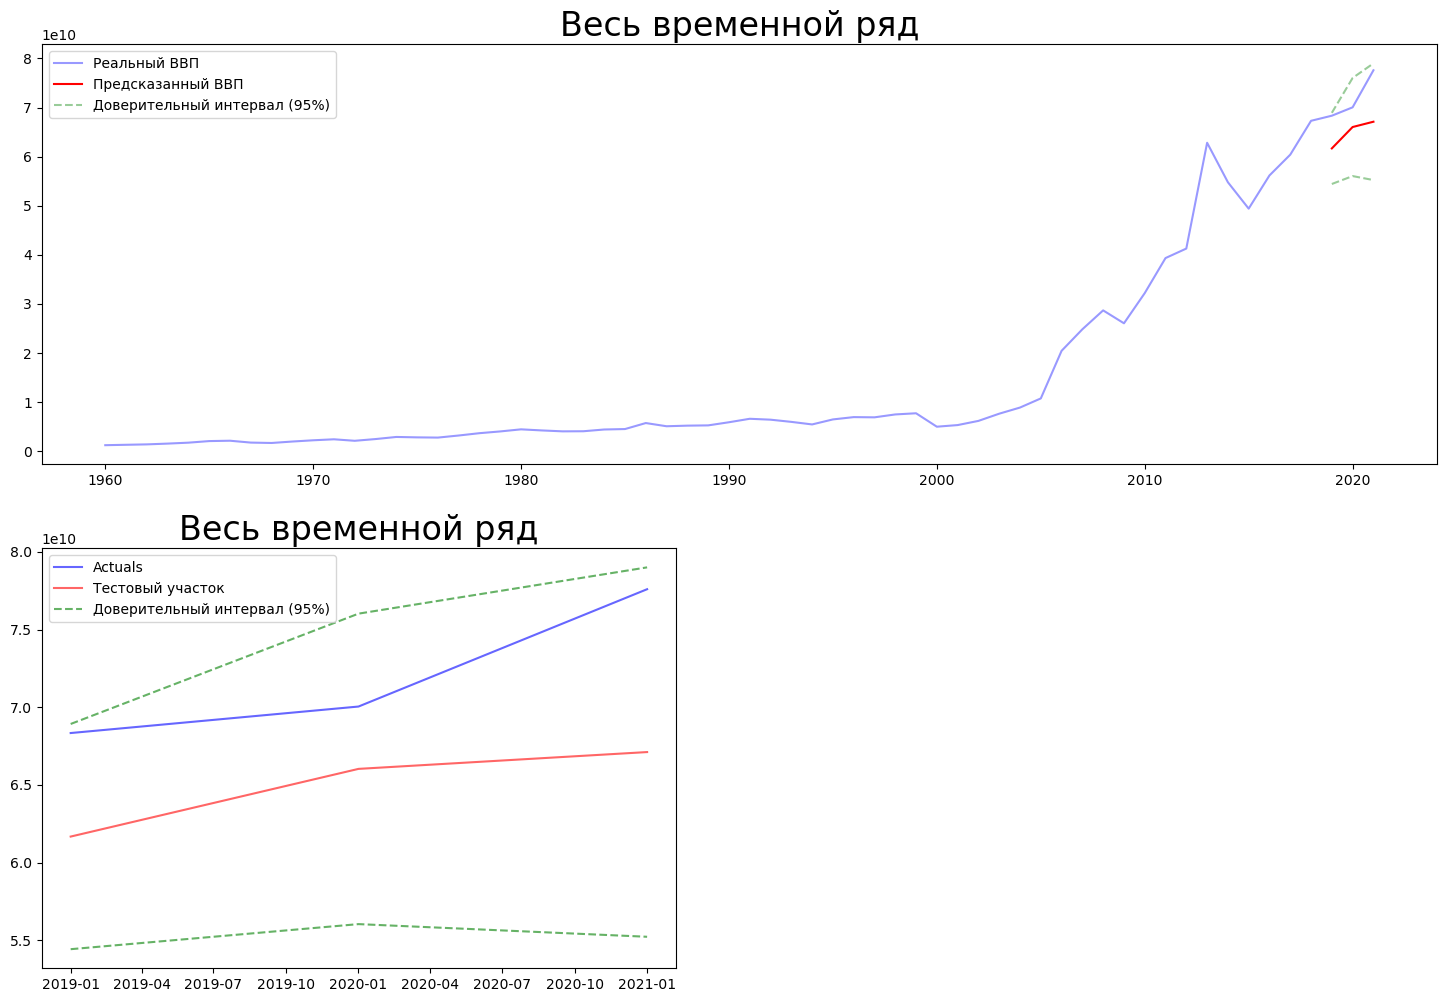

In [37]:
data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data = data.rename(columns={'GDP (current US$)':'gdp'})
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x==0 else x)
data = data.interpolate()

train_df = data.iloc[:-3]
test_df = data.iloc[-3:]

plot_acf_pacf(train_df["gdp"].dropna())

test = adfuller(train_df["gdp"].diff().diff().dropna()) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["10%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")
    
model_best = SARIMAX(
train_df["gdp"].dropna(), order=(2, 1, 3), seasonal_order=(0, 1, 2, 5))
model_fit_best = model_inter.fit()

print(model_fit_best.summary())

pred_df = pd.DataFrame(index=data.index)
pred_df["model_preds"] = model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1])


pred_df["gdp"] = data["gdp"]

forecast = model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["gdp"], color="blue", label="Реальный ВВП", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Предсказанный ВВП",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["gdp"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Тестовый участок",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Весь временной ряд", size=24)
plt.legend()

plt.show()

## Итоговые выводы:

* Временной ряд имеет явный тренд (на рост)

* По алгоритму выбора модели получаем:

* * Ряд стационарен? **нет**
* * Экзогенные переменные? **нет**
* * Сезонность? **нет**
* * гетероскедастичность? **нет**
* * **ARIMA**

* Предсказания модели показывают несколько меньший рост (что зная специфику графиков роста ВВП является удовлетворительным)

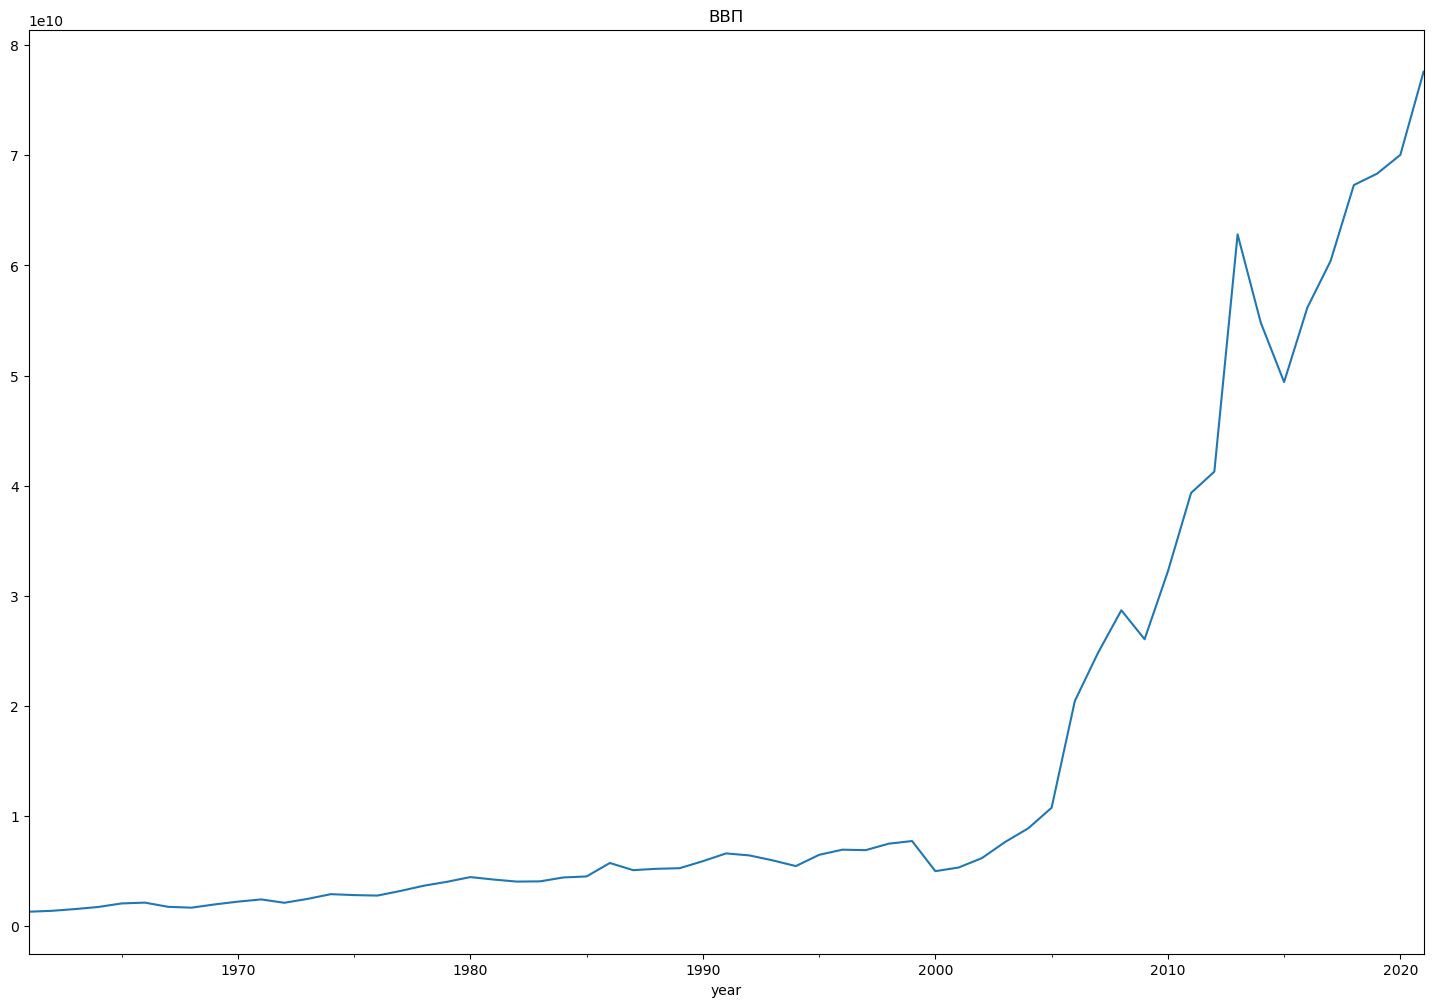

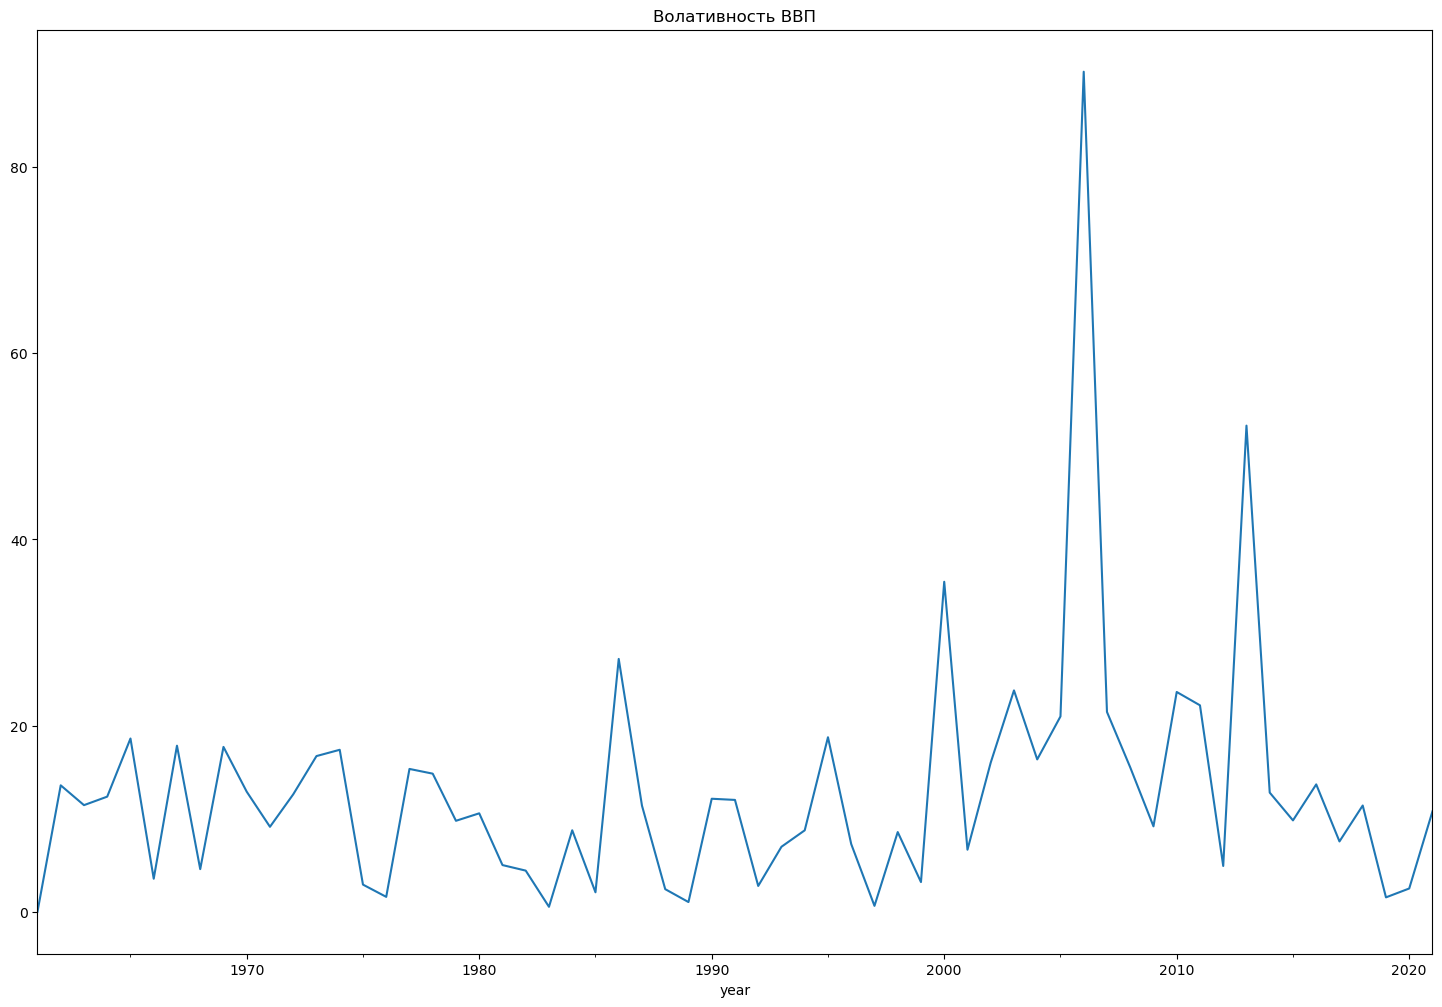

adf:  -6.894157867927704
p-value:  1.3320795444075047e-09
Critical values:  {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}
ряд стационарен


In [38]:
# Подготовим ряд и определим волативность
df = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df = df.rename(columns={'GDP (current US$)':'gdp'})
df['gdp'] = df['gdp'].apply(lambda x: np.nan if x==0 else x)  
df['gdp_vol'] = (df['gdp'] - df['gdp'].shift(1))/df['gdp'].shift(1)
df['gdp_vol'] = df['gdp'].pct_change(1).mul(100).abs()
df = df.interpolate()
df = df.dropna()

# Визуализируем данные
df['gdp'].plot()
plt.title('ВВП')
plt.show()

df['gdp_vol'].plot()
plt.title('Волативность ВВП')
plt.show()

test = adfuller(df["gdp_vol"]) # Исходный ряд
print("adf: ", test[0])
print("p-value: ", test[1])
print("Critical values: ", test[4])
if test[0] > test[4]["1%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

Iteration:      1,   Func. Count:      8,   Neg. LLF: 535.1157601661973
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1078.1743141505717
Iteration:      3,   Func. Count:     29,   Neg. LLF: 256.8100025766913
Iteration:      4,   Func. Count:     37,   Neg. LLF: 246.0037622582362
Iteration:      5,   Func. Count:     45,   Neg. LLF: 254.24035355693294
Iteration:      6,   Func. Count:     54,   Neg. LLF: 234.36475395570534
Iteration:      7,   Func. Count:     61,   Neg. LLF: 234.32637868153472
Iteration:      8,   Func. Count:     68,   Neg. LLF: 234.27318810779695
Iteration:      9,   Func. Count:     75,   Neg. LLF: 234.26504618405764
Iteration:     10,   Func. Count:     82,   Neg. LLF: 234.2516449978672
Iteration:     11,   Func. Count:     89,   Neg. LLF: 236.66789568035765
Iteration:     12,   Func. Count:     98,   Neg. LLF: 276.23411664380166
Iteration:     13,   Func. Count:    108,   Neg. LLF: 234.2409222316932
Iteration:     14,   Func. Count:    117,   Neg. LLF: 23

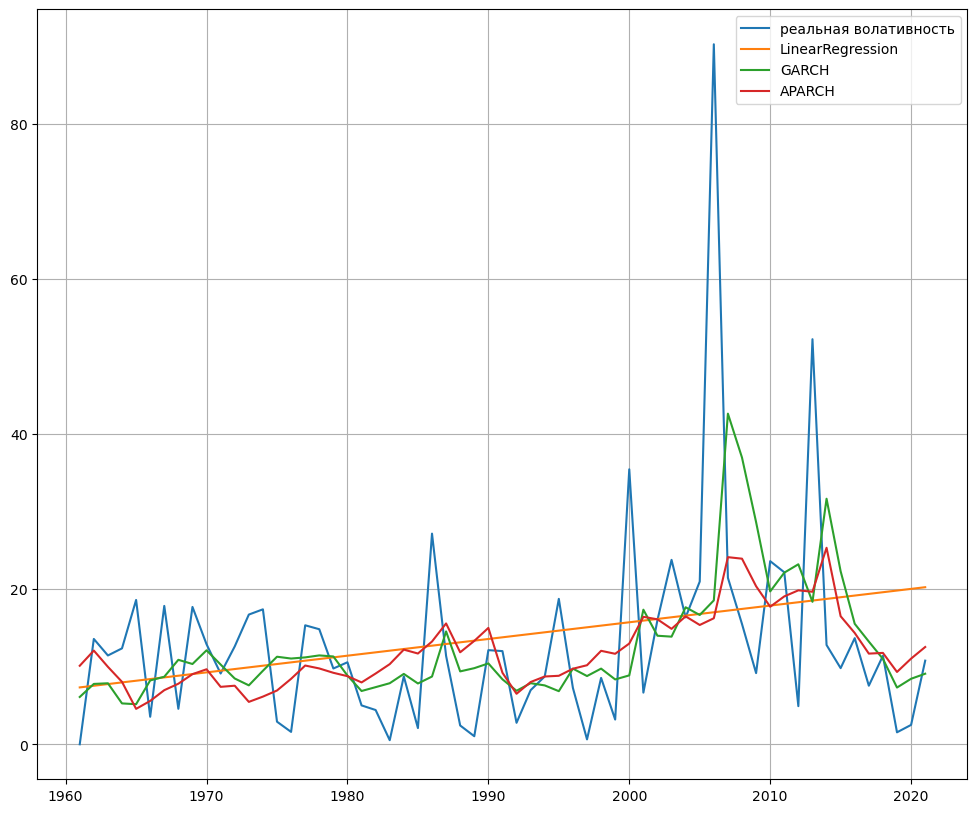

In [39]:
# Разобьём сет на train test
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]
X_train = pd.DataFrame(range(df["gdp_vol"].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(df["gdp_vol"].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df["gdp_vol"].values
y_test = test_df["gdp_vol"].values

# Моделируем LR
lr = LinearRegression().fit(X_train, y_train)
y_pred_train_lr = lr.predict(X_train)
y_pred_test_lr = lr.predict(X_test)
lr_predict = np.append(y_pred_train_lr, y_pred_test_lr)

# Моделируем ARCH
garch = arch_model(df["gdp_vol"], p=2, o=1, q=1, power=0.5, vol='GARCH').fit()
garch_1 = arch_model(df["gdp_vol"], vol='APARCH').fit()

# Отрисуем результаты
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(df['gdp_vol'], label='реальная волативность')
ax.plot(pd.Series(lr_predict, index=df.index), label='LinearRegression')
ax.plot(garch.conditional_volatility, label='GARCH')
ax.plot(garch_1.conditional_volatility, label='APARCH')
ax.grid()
ax.legend();

In [70]:
df

,gdp,gdp_vol
year,,
1961-01-01,1.299720e+09,0.000000
1962-01-01,1.382353e+09,13.578826
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
1965-01-01,2.053221e+09,18.608414
...,...,...
2017-01-01,6.040638e+10,7.551317
2018-01-01,6.729928e+10,11.410877
2019-01-01,6.833754e+10,1.542746


In [52]:
train_df["gdp_vol"].dropna()

year
1961-01-01     0.000000
1962-01-01    13.578826
1963-01-01    11.448835
1964-01-01    12.363636
1965-01-01    18.608414
1966-01-01     3.547067
1967-01-01    17.837977
1968-01-01     4.573826
1969-01-01    17.705882
1970-01-01    12.893553
1971-01-01     9.123051
1972-01-01    12.610723
1973-01-01    16.721166
1974-01-01    17.396804
1975-01-01     2.912634
1976-01-01     1.596101
1977-01-01    15.339433
1978-01-01    14.831798
1979-01-01     9.767969
1980-01-01    10.571547
1981-01-01     5.011815
1982-01-01     4.415626
1983-01-01     0.527271
1984-01-01     8.749833
1985-01-01     2.086502
1986-01-01    27.157362
1987-01-01    11.396962
1988-01-01     2.423944
1989-01-01     1.037417
1990-01-01    12.137075
1991-01-01    12.011383
1992-01-01     2.768791
1993-01-01     6.979306
1994-01-01     8.744096
1995-01-01    18.744891
1996-01-01     7.267395
1997-01-01     0.629794
1998-01-01     8.556579
1999-01-01     3.186566
2000-01-01    35.447657
2001-01-01     6.660324
2002-01-01 

In [53]:
df.index.year.values[::5]

array([1961, 1966, 1971, 1976, 1981, 1986, 1991, 1996, 2001, 2006, 2011,
       2016, 2021])

Iteration:      3,   Func. Count:     23,   Neg. LLF: 240.0357547021828
Iteration:      6,   Func. Count:     42,   Neg. LLF: 229.9691214537941
Iteration:      9,   Func. Count:     61,   Neg. LLF: 227.02169688214428
Iteration:     12,   Func. Count:     79,   Neg. LLF: 227.01100646496693
Iteration:     15,   Func. Count:     96,   Neg. LLF: 227.01092531821524
Optimization terminated successfully    (Exit mode 0)
            Current function value: 227.01092537367597
            Iterations: 15
            Function evaluations: 96
            Gradient evaluations: 15


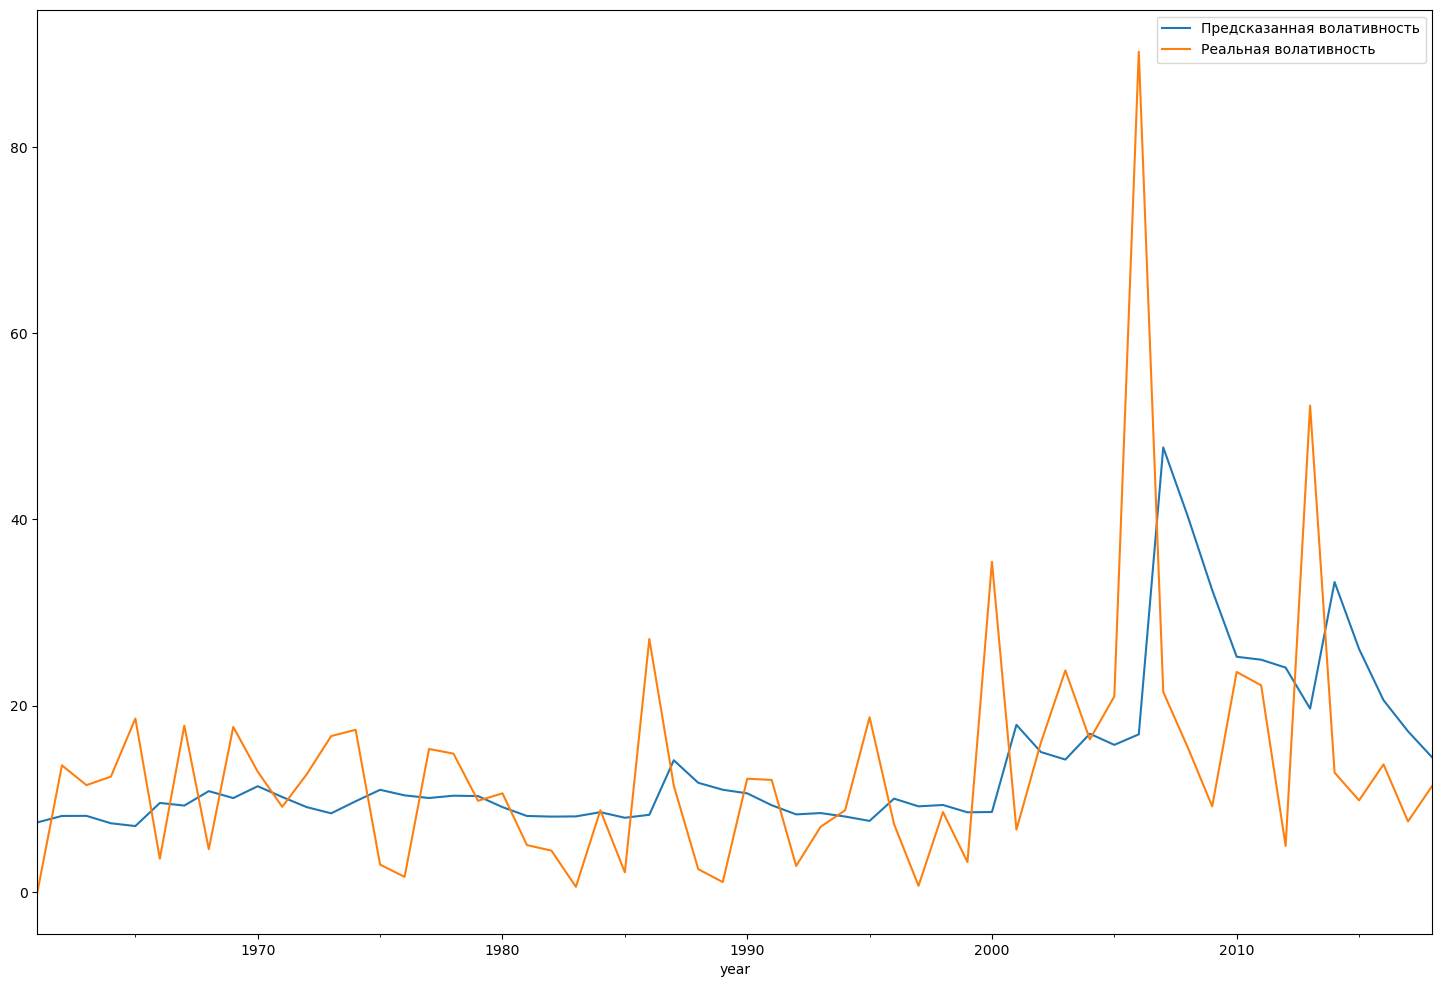

In [40]:
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

from arch import arch_model
am = arch_model(train_df.gdp_vol.dropna(), p=1, o=1, q=1, power=1.0)
res = am.fit(update_freq=3)
plot_df = pd.concat([res.conditional_volatility, train_df.gdp_vol.dropna()], axis=1)
plot_df.columns = ["Предсказанная волативность", "Реальная волативность"]
subplot = plot_df.plot()

In [55]:
train_df

,gdp,gdp_vol
year,,
1961-01-01,1.299720e+09,0.000000
1962-01-01,1.382353e+09,13.578826
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636
1965-01-01,2.053221e+09,18.608414
1966-01-01,2.126050e+09,3.547067
1967-01-01,1.746806e+09,17.837977
1968-01-01,1.666910e+09,4.573826
1969-01-01,1.962051e+09,17.705882


In [41]:
data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data['GDP (current US$)'] = data["GDP (current US$)"].apply(lambda x: np.nan if x==0 else x)  
data["GDP_vol"] = data["GDP (current US$)"].pct_change(1).mul(100).abs()


train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]


#plt.rcParams["figure.figsize"] = 10,4

#plot_acf_pacf(train_df["GDP_vol"][1:])
#plt.show()

#adfuller(train_df["GDP_vol"][1:])

# стационарен, p=1, q=1


garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])
garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

from arch import arch_model

model = arch_model(garch_df["GDP_vol"].dropna(), p=2, o=1, q=1, power=0.5, vol='GARCH')
model_results = model.fit()

# 4-кратное улучшение AIC до 461

predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.conditional_volatility

Iteration:      1,   Func. Count:      8,   Neg. LLF: 535.1157601661973
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1078.1743141505717
Iteration:      3,   Func. Count:     29,   Neg. LLF: 256.8100025766913
Iteration:      4,   Func. Count:     37,   Neg. LLF: 246.0037622582362
Iteration:      5,   Func. Count:     45,   Neg. LLF: 254.24035355693294
Iteration:      6,   Func. Count:     54,   Neg. LLF: 234.36475395570534
Iteration:      7,   Func. Count:     61,   Neg. LLF: 234.32637868153472
Iteration:      8,   Func. Count:     68,   Neg. LLF: 234.27318810779695
Iteration:      9,   Func. Count:     75,   Neg. LLF: 234.26504618405764
Iteration:     10,   Func. Count:     82,   Neg. LLF: 234.2516449978672
Iteration:     11,   Func. Count:     89,   Neg. LLF: 236.66789568035765
Iteration:     12,   Func. Count:     98,   Neg. LLF: 276.23411664380166
Iteration:     13,   Func. Count:    108,   Neg. LLF: 234.2409222316932
Iteration:     14,   Func. Count:    117,   Neg. LLF: 23

Iteration:      1,   Func. Count:      8,   Neg. LLF: 535.1157601661973
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1078.1743141505717
Iteration:      3,   Func. Count:     29,   Neg. LLF: 256.8100025766913
Iteration:      4,   Func. Count:     37,   Neg. LLF: 246.0037622582362
Iteration:      5,   Func. Count:     45,   Neg. LLF: 254.24035355693294
Iteration:      6,   Func. Count:     54,   Neg. LLF: 234.36475395570534
Iteration:      7,   Func. Count:     61,   Neg. LLF: 234.32637868153472
Iteration:      8,   Func. Count:     68,   Neg. LLF: 234.27318810779695
Iteration:      9,   Func. Count:     75,   Neg. LLF: 234.26504618405764
Iteration:     10,   Func. Count:     82,   Neg. LLF: 234.2516449978672
Iteration:     11,   Func. Count:     89,   Neg. LLF: 236.66789568035765
Iteration:     12,   Func. Count:     98,   Neg. LLF: 276.23411664380166
Iteration:     13,   Func. Count:    108,   Neg. LLF: 234.2409222316932
Iteration:     14,   Func. Count:    117,   Neg. LLF: 23

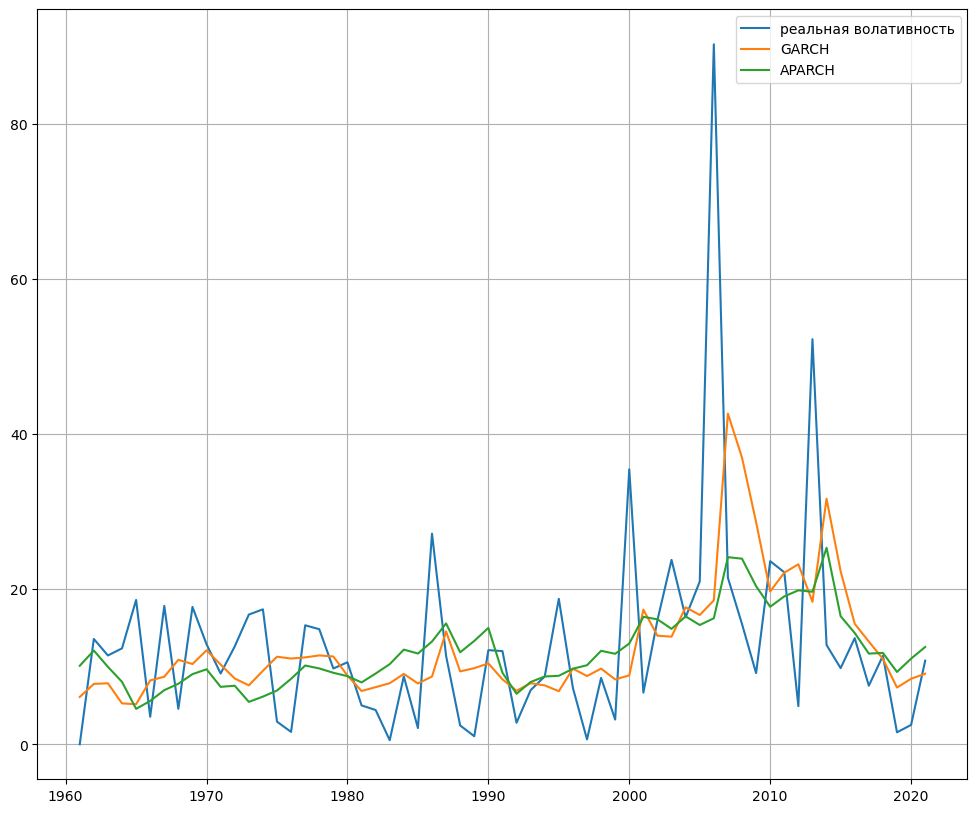

In [42]:
garch = arch_model(data["GDP_vol"].dropna(), p=2, o=1, q=1, power=0.5, vol='GARCH').fit()
garch_1 = arch_model(data["GDP_vol"].dropna(), vol='APARCH').fit()

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(data["GDP_vol"], label='реальная волативность')
ax.plot(garch.conditional_volatility, label='GARCH')
ax.plot(garch_1.conditional_volatility, label='APARCH')
ax.grid()
ax.legend();

Iteration:      1,   Func. Count:      6,   Neg. LLF: 237.47500389125557
Iteration:      2,   Func. Count:     12,   Neg. LLF: 226.55667323629484
Iteration:      3,   Func. Count:     17,   Neg. LLF: 226.48900414034063
Iteration:      4,   Func. Count:     22,   Neg. LLF: 225.92793743879244
Iteration:      5,   Func. Count:     27,   Neg. LLF: 237.23976052114836
Iteration:      6,   Func. Count:     33,   Neg. LLF: 234.63584797338865
Iteration:      7,   Func. Count:     39,   Neg. LLF: 231.94360191539337
Iteration:      8,   Func. Count:     45,   Neg. LLF: 248.19868203013905
Iteration:      9,   Func. Count:     51,   Neg. LLF: 229.21944947677113
Iteration:     10,   Func. Count:     57,   Neg. LLF: 226.92997422997243
Iteration:     11,   Func. Count:     63,   Neg. LLF: 225.25554067343978
Iteration:     12,   Func. Count:     69,   Neg. LLF: 223.95330259923102
Iteration:     13,   Func. Count:     74,   Neg. LLF: 223.44171642643875
Iteration:     14,   Func. Count:     79,   Neg. LL

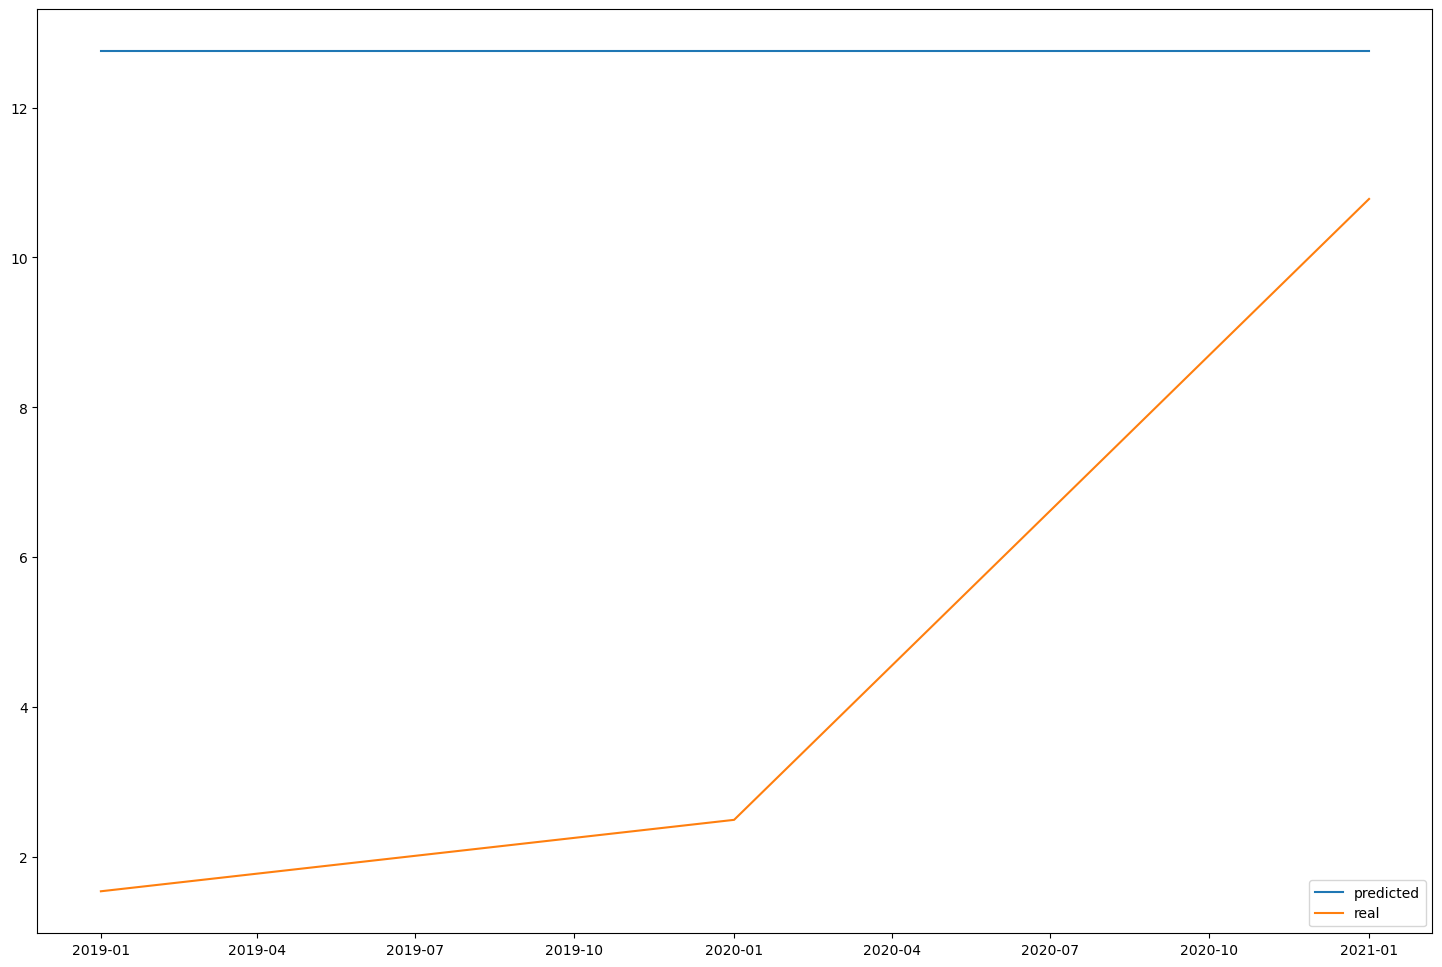

In [43]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

#Читаем и подготавливаем данные
data = pd.read_csv("ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
data['GDP (current US$)'] = data["GDP (current US$)"].apply(lambda x: np.nan if x==0 else x)
data["GDP_vol"] = data["GDP (current US$)"].pct_change(1).mul(100).abs()
data = data.dropna() 
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]

#Моделируем прогноз на последние 3 года
am = arch_model(data['GDP_vol'], vol="GARCH")
res = am.fit(last_obs=dt.datetime(2019,1,1))
forecasts = res.forecast()

#Визуализируем результаты
plt.plot(forecasts.mean[-3:], label='predicted')
plt.plot(test_df['GDP_vol'], label='real')
plt.legend();